Step 0, Loss: 0.17526693642139435
Step 200, Loss: 0.1401502788066864
Step 400, Loss: 0.13957644999027252
Step 600, Loss: 0.13845789432525635
Step 800, Loss: 0.13723452389240265
Step 1000, Loss: 0.13680386543273926
Step 1200, Loss: 0.13660678267478943
Step 1400, Loss: 0.13653211295604706
Step 1600, Loss: 0.13653624057769775
Step 1800, Loss: 0.13649551570415497
Step 2000, Loss: 0.13644789159297943
Step 2200, Loss: 0.13645340502262115
Step 2400, Loss: 0.13641615211963654
Step 2600, Loss: 0.13644728064537048
Step 2800, Loss: 0.1363893449306488
Step 3000, Loss: 0.1365591287612915
Step 3200, Loss: 0.13634978234767914
Step 3400, Loss: 0.13648849725723267
Step 3600, Loss: 0.1362156718969345
Step 3800, Loss: 0.13612142205238342
Step 4000, Loss: 0.13620807230472565
Step 4200, Loss: 0.13696181774139404
Step 4400, Loss: 0.13634078204631805
Step 4600, Loss: 0.1361158937215805
Step 4800, Loss: 0.13465794920921326
Step 5000, Loss: 0.13539910316467285
Step 5200, Loss: 0.13509304821491241
Step 5400, Lo

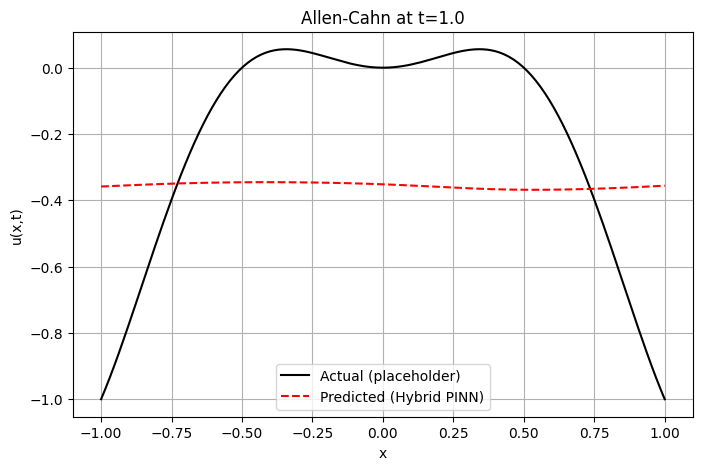

In [27]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

# -----------------------------
# PDE Setup
# -----------------------------
# PDE: u_t - 0.0001 u_xx + 5u^3 - 5u = 0
# Domain: x in [-1,1], t in [0,1]
# Initial condition: u(x,0) = x^2 cos(pi x)
# Boundary conditions:
#   u(t,-1) = u(t,1)
#   u_x(t,-1) = u_x(t,1)

domain_x = jnp.linspace(-1.0, 1.0, 128)
domain_t = jnp.linspace(0.0, 1.0, 100)
X, T = jnp.meshgrid(domain_x, domain_t, indexing='xy')

def initial_condition(x):
    return x**2 * jnp.cos(jnp.pi * x)

U0 = initial_condition(domain_x)

def U_actual(x, t):
    # Placeholder for actual solution.
    # Replace this with a reference solution if available.
    # Otherwise, this function can just return something simple.
    # For demonstration, we return the initial condition (no real evolution).
    return initial_condition(x)

# PDE coefficients
diff_coeff = 0.0001

# -----------------------------
# Neural Network Definitions
# -----------------------------
class KAN(nn.Module):
    width: int = 64
    depth: int = 3
    @nn.compact
    def __call__(self, x, t):
        # x, t shape: (batch, 1)
        xt = jnp.concatenate([x, t], axis=1)  # (batch,2)
        for _ in range(self.depth):
            xt = nn.tanh(nn.Dense(self.width)(xt))
        return nn.Dense(1)(xt)  # (batch,1)

class TemporalSSM(nn.Module):
    hidden_dim: int = 64
    @nn.compact
    def __call__(self, u_spatial, t):
        # u_spatial: (batch,1), t: (batch,1)
        h = jnp.concatenate([u_spatial, t], axis=1)  # (batch,2)
        h = nn.tanh(nn.Dense(self.hidden_dim)(h))    # (batch, hidden_dim)
        u_corr = nn.Dense(1)(h)                      # (batch,1)
        return u_spatial + u_corr                    # (batch,1)

class HybridPINN(nn.Module):
    kan_width: int = 64
    kan_depth: int = 3
    ssm_hidden: int = 64
    @nn.compact
    def __call__(self, x, t):
        u_kan = KAN(width=self.kan_width, depth=self.kan_depth)(x, t)
        u_out = TemporalSSM(hidden_dim=self.ssm_hidden)(u_kan, t)
        return u_out

model = HybridPINN()
params = model.init(jax.random.PRNGKey(0), jnp.ones((1,1)), jnp.ones((1,1)))

# -----------------------------
# Pointwise evaluation
# -----------------------------
def f_xt_point(params, x, t):
    x_in = jnp.array(x, ndmin=1).reshape(1,1)
    t_in = jnp.array(t, ndmin=1).reshape(1,1)
    val = model.apply(params, x_in, t_in)
    return val[0,0]

def pde_residual(params, X, T):
    # PDE: u_t - 0.0001 u_xx + 5u^3 - 5u = 0
    def single_point_residual(x, t):
        def u_fun_x(x_):
            return f_xt_point(params, x_, t)
        def u_fun_t(t_):
            return f_xt_point(params, x, t_)

        u_val = f_xt_point(params, x, t)
        u_x_val = jax.grad(u_fun_x)(x)
        u_xx_val = jax.grad(lambda xx: jax.grad(u_fun_x)(xx))(x)
        u_t_val = jax.grad(u_fun_t)(t)

        # Residual
        return u_t_val - diff_coeff * u_xx_val + 5*u_val**3 - 5*u_val

    X_flat = X.flatten()
    T_flat = T.flatten()
    return jax.vmap(single_point_residual)(X_flat, T_flat)

def loss_fn(params):
    # PDE loss
    r = pde_residual(params, X, T)
    pde_loss = jnp.mean(r**2)

    # Initial condition: u(x,0) = x^2 cos(pi x)
    u0_pred = jax.vmap(lambda x: f_xt_point(params, x, 0.0))(domain_x)
    ic_loss = jnp.mean((u0_pred - U0)**2)

    # Periodic BC:
    # u(t,-1) = u(t,1) and u_x(t,-1) = u_x(t,1)
    u_left = jax.vmap(lambda tt: f_xt_point(params, -1.0, tt))(domain_t)
    u_right = jax.vmap(lambda tt: f_xt_point(params, 1.0, tt))(domain_t)
    bc_loss_u = jnp.mean((u_left - u_right)**2)

    def ux_fun_left(t_):
        return jax.grad(lambda x_: f_xt_point(params, x_, t_))(-1.0)
    def ux_fun_right(t_):
        return jax.grad(lambda x_: f_xt_point(params, x_, t_))(1.0)

    ux_left = jax.vmap(ux_fun_left)(domain_t)
    ux_right = jax.vmap(ux_fun_right)(domain_t)
    bc_loss_ux = jnp.mean((ux_left - ux_right)**2)

    return pde_loss + ic_loss + bc_loss_u + bc_loss_ux

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state):
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# Training (fewer steps for demonstration)
for i in range(10000):
    params, opt_state = train_step(params, opt_state)
    if i % 200 == 0:
        print(f"Step {i}, Loss: {loss_fn(params)}")

# -----------------------------
# Plotting Function
# -----------------------------
def plot_predicted_vs_actual(params, time_slice=1.0):
    x_plot = domain_x
    u_pred = jax.vmap(lambda xx: f_xt_point(params, xx, time_slice))(x_plot)
    u_true = U_actual(x_plot, time_slice)

    plt.figure(figsize=(8,5))
    plt.plot(x_plot, u_true, 'k-', label='Actual (placeholder)')
    plt.plot(x_plot, u_pred, 'r--', label='Predicted (Hybrid PINN)')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Allen-Cahn at t={time_slice}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results at t=1.0
plot_predicted_vs_actual(params, time_slice=1.0)


In [28]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import itertools
import matplotlib.pyplot as plt

# --------------------------------------
# PDE Setup for Allen-Cahn
# --------------------------------------
Lx = 2.0
x_min, x_max = -1.0, 1.0
T_final = 1.0
Nt = 100    # number of time points
Nx = 256    # number of spatial points

domain_t = jnp.linspace(0.0, T_final, Nt)    # t_0=0, t_Nt=1
domain_x = jnp.linspace(x_min, x_max, Nx)
X, T = jnp.meshgrid(domain_x, domain_t, indexing='xy')

# PDE coefficients
diff_coeff = 0.0001

def initial_condition(x):
    return x**2 * jnp.cos(jnp.pi * x)

U0 = initial_condition(domain_x)

# --------------------------------------
# Fourier Feature Embedding for Periodicity
# We encode x into Fourier features to enforce periodic BC exactly.
# --------------------------------------
def fourier_features(x, m=10):
    # x shape: (batch,)
    # produce features: [1, sin(ωx), cos(ωx), sin(2ωx), cos(2ωx), ... sin(mωx), cos(mωx)]
    # ω = 2π / (x_max - x_min) = 2π/2 = π
    w = jnp.pi
    ff = [jnp.ones_like(x)]
    for k in range(1, m+1):
        ff.append(jnp.sin(k * w * x))
        ff.append(jnp.cos(k * w * x))
    return jnp.stack(ff, axis=1)  # shape (batch, 2m+1)

# --------------------------------------
# Neural Network Model (As in manuscript: MLP with tanh)
# 4 hidden layers, 128 neurons each
# Input: (t, FourierFeatures(x))
# Output: u(t,x)
# --------------------------------------
class MLP(nn.Module):
    layers: int = 4
    width: int = 128
    
    @nn.compact
    def __call__(self, t, x):
        # t shape: (batch, 1)
        # x shape: (batch, 2m+1) from Fourier features
        # input: concatenate t and x features
        inp = jnp.hstack([t, x])
        for _ in range(self.layers):
            inp = nn.tanh(nn.Dense(self.width)(inp))
        out = nn.Dense(1)(inp)
        return out

m = 10
model = MLP(layers=4, width=128)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1,1)), jnp.ones((1,2*m+1))) 

# --------------------------------------
# Pointwise evaluation
# f_xt_point: Evaluate u(t,x) at a scalar t,x
# --------------------------------------
def f_xt_point(params, t, x):
    # shapes (1,1) and (1,) for x->(1,2m+1)
    t_in = jnp.array(t, ndmin=1).reshape(1,1)
    x_in = jnp.array(x, ndmin=1)
    x_ff = fourier_features(x_in, m=m) # (1, 2m+1)
    val = model.apply(params, t_in, x_ff)  # (1,1)
    return val[0,0]

# Derivatives for PDE
def u_t(params, t, x):
    return jax.grad(lambda tt: f_xt_point(params, tt, x))(t)

def u_x(params, t, x):
    return jax.grad(lambda xx: f_xt_point(params, t, xx))(x)

def u_xx(params, t, x):
    return jax.grad(lambda xx: u_x(params, t, xx))(x)

# PDE residual at a single point (t,x)
def pde_residual_point(params, t, x):
    u_val = f_xt_point(params, t, x)
    u_t_val = u_t(params, t, x)
    u_xx_val = u_xx(params, t, x)
    # PDE: u_t -0.0001 u_xx + 5u^3 - 5u = 0
    return u_t_val - diff_coeff * u_xx_val + 5*u_val**3 - 5*u_val

# --------------------------------------
# Loss functions for a given set of points
# --------------------------------------
# We'll discretize time and space to define temporal slices.
# For causal training:
# Let t_i be the i-th time, 
# Compute L_ic at t_0,
# Compute PDE residual at t_i, i=1,...,N_t

t_array = jnp.linspace(0, T_final, Nt)
x_array = jnp.linspace(x_min, x_max, Nx)

# IC loss at t=0
def ic_loss(params):
    u_pred = jax.vmap(lambda x: f_xt_point(params, 0.0, x))(x_array)
    return jnp.mean((u_pred - U0)**2)

# PDE residual loss at a given time t_i
def pde_loss_at_t(params, t_val):
    # Sample Nx points in space (full batch)
    # PDE residual
    r = jax.vmap(lambda x: pde_residual_point(params, t_val, x))(x_array)
    return jnp.mean(r**2)

# For causal training:
# We define:
# L(t_0,θ) = λ_ic * IC_loss
# L(t_i,θ) = PDE residual at t_i
# Weighted sum:
# L_total = (1/Nt)*[w_0 * L(t_0,θ) + sum_{i=1}^{Nt-1} w_i * L(t_i,θ)]

lambda_ic = 100.0
lambda_r = 1.0
delta = 0.99  # stopping criterion
epsilons = [1e-2, 1e-1, 1e0, 1e1, 1e2]  # annealing sequence for epsilon

# We store PDE residuals at each time step
def compute_all_losses(params):
    # returns L_ic and array of PDE losses [L(t_1), ..., L(t_Nt-1)]
    L_ic_val = ic_loss(params)
    pde_vals = jax.vmap(lambda tt: pde_loss_at_t(params, tt))(t_array[1:]) 
    return L_ic_val, pde_vals

# Causal weights update:
def update_weights(L_ic_val, pde_vals, epsilon):
    # pde_vals: shape (Nt-1,)
    # w_0 = 1 always
    # w_i = exp(-ε * sum_{k=1}^{i-1} L_r(t_k))
    # but we also include IC as first temporal slice
    # indexing:
    # t_0: IC
    # t_1,... t_(Nt-1): PDE residual times
    # cumulative sums
    # sum_{k=1}^{i-1} L_r(t_k) includes L_ic as first? The manuscript sets w_1 corresponding to PDE at t_1 should depend on L_ic(t_0):
    # Actually, manuscript states: treat IC as t_0. Then:
    # w_0 = 1
    # For i=1,... w_i = exp(-ε * sum_{k=0}^{i-1} L_r(t_k)) but L_r(t_0) = λ_ic * L_ic
    # Here L_r(t_0)=λ_ic * L_ic_val
    # For PDE times:
    Lr_t0 = lambda_ic * L_ic_val
    cum_losses = jnp.cumsum(pde_vals) # L(t_1)+...+L(t_i)
    # w_1 = exp(-ε * L_r(t_0)) = exp(-ε * λ_ic * L_ic_val)
    # w_2 = exp(-ε (L_r(t_0)+L_r(t_1))) ...
    # general:
    # w_i = exp(-ε (L_r(t_0) + sum_{k=1}^{i-1}L_r(t_k))) for i>=1
    w_arr = []
    for i in range(len(pde_vals)+1):
        if i == 0:
            # i=0 => w_0=1
            w_arr.append(1.0)
        else:
            sum_prev = Lr_t0 + cum_losses[i-1] if i>0 else Lr_t0
            w_arr.append(jnp.exp(-epsilon * sum_prev))
    w_arr = jnp.array(w_arr) # shape (Nt)
    return w_arr

def total_loss(params, w_arr, L_ic_val, pde_vals):
    Lr_t0 = lambda_ic * L_ic_val
    # L_total = (1/Nt)[w_0*Lr_t0 + sum_{i=1}^{Nt-1} w_i * Lr(t_i)]
    # Lr(t_i)=pde_vals[i-1] for i>=1
    weighted_sum = w_arr[0]*Lr_t0 + jnp.sum(w_arr[1:] * pde_vals)
    return weighted_sum / Nt

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, epsilon):
    # compute losses
    L_ic_val, pde_vals = compute_all_losses(params)
    # stop gradient for w calculation
    w_arr = update_weights(jax.lax.stop_gradient(L_ic_val), 
                           jax.lax.stop_gradient(pde_vals),
                           epsilon)
    def loss_fn(params):
        L_ic_val_, pde_vals_ = compute_all_losses(params)
        w_arr_ = update_weights(L_ic_val_, pde_vals_, epsilon)
        return total_loss(params, w_arr_, L_ic_val_, pde_vals_)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, L_ic_val, pde_vals, w_arr

# --------------------------------------
# Causal training loop with epsilon annealing and stopping criterion
# --------------------------------------
max_iterations = 300_000
eps_idx = 0
epsilon = epsilons[eps_idx]

for i in range(max_iterations):
    params, opt_state, L_ic_val, pde_vals, w_arr = train_step(params, opt_state, epsilon)
    
    # Check if we can move to next epsilon
    # Once we see that min(w_arr) > delta, we can move to next epsilon
    if jnp.min(w_arr) > delta:
        eps_idx += 1
        if eps_idx < len(epsilons):
            epsilon = epsilons[eps_idx]
        else:
            # all eps done, we can break
            break
    
    if i % 1000 == 0:
        curr_loss = total_loss(params, w_arr, L_ic_val, pde_vals)
        print(f"Iteration {i}, Loss: {curr_loss}, min(w): {jnp.min(w_arr)}")

# After training, we have causal trained params for Allen-Cahn
# Plot final predictions
def plot_predicted_vs_actual(params, time_slice=1.0):
    x_plot = domain_x
    u_pred = jax.vmap(lambda x: f_xt_point(params, time_slice, x))(x_plot)
    # If you have a reference solution from a spectral solver:
    U_true = initial_condition(x_plot) # Replace with actual solution at t=1 if available
    plt.figure(figsize=(8,5))
    plt.plot(x_plot, U_true, 'k-', label='Exact')
    plt.plot(x_plot, u_pred, 'r--', label='PINN Prediction')
    plt.xlabel('x')
    plt.ylabel('u(x,t=1)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_predicted_vs_actual(params, time_slice=1.0)


Iteration 0, Loss: 0.7336998581886292, min(w): 0.28077834844589233
Iteration 1000, Loss: 0.13080623745918274, min(w): 0.8758147358894348
Iteration 2000, Loss: 0.13062238693237305, min(w): 0.875885009765625
Iteration 3000, Loss: 0.1304931789636612, min(w): 0.8760992288589478
Iteration 4000, Loss: 0.12837058305740356, min(w): 0.8777475357055664
Iteration 5000, Loss: 0.10851781815290451, min(w): 0.8959079384803772
Iteration 6000, Loss: 0.08905813843011856, min(w): 0.9138906598091125
Iteration 7000, Loss: 0.07228570431470871, min(w): 0.9296549558639526
Iteration 8000, Loss: 0.061573248356580734, min(w): 0.9398207068443298
Iteration 9000, Loss: 0.05195173993706703, min(w): 0.9490097165107727
Iteration 10000, Loss: 0.04358573630452156, min(w): 0.9570746421813965
Iteration 11000, Loss: 0.031178824603557587, min(w): 0.969135046005249


KeyboardInterrupt: 

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

# --------------------------------------
# PDE Setup: Allen-Cahn
# --------------------------------------
x_min, x_max = -1.0, 1.0
T_final = 1.0
Nx = 256
Nt = 100
domain_x = jnp.linspace(x_min, x_max, Nx)
domain_t = jnp.linspace(0.0, T_final, Nt)

def initial_condition(x):
    return x**2 * jnp.cos(jnp.pi * x)

U0 = initial_condition(domain_x)

diff_coeff = 0.0001

# Fourier features for periodic BC
def fourier_features(x, m=10):
    # x: (batch,)
    # Output: (batch, 2*m+1)
    w = jnp.pi  # since period is 2.0, ω = 2π/(x_max - x_min) = 2π/2 = π
    features = [jnp.ones_like(x)]
    for k in range(1, m+1):
        features.append(jnp.sin(k*w*x))
        features.append(jnp.cos(k*w*x))
    return jnp.stack(features, axis=1)  # (batch, 2*m+1)

m = 10

# --------------------------------------
# Hybrid PINN Model (KAN + MAMBA-inspired TemporalSSM)
# --------------------------------------
class KAN(nn.Module):
    width: int
    depth: int
    @nn.compact
    def __call__(self, t, x_ff):
        # t: (batch,1), x_ff: (batch, 2m+1)
        # Combine t and x_ff -> (batch, 2m+2)
        inp = jnp.hstack([t, x_ff])
        for _ in range(self.depth):
            inp = nn.tanh(nn.Dense(self.width)(inp))
        return nn.Dense(1)(inp)  # (batch,1)

class TemporalSSM(nn.Module):
    hidden_dim: int
    @nn.compact
    def __call__(self, u_spatial, t):
        # u_spatial: (batch,1), t: (batch,1)
        h = jnp.concatenate([u_spatial, t], axis=1)  # (batch,2)
        h = nn.tanh(nn.Dense(self.hidden_dim)(h))
        u_corr = nn.Dense(1)(h)  # (batch,1)
        return u_spatial + u_corr

class HybridPINN(nn.Module):
    kan_width: int
    kan_depth: int
    ssm_hidden: int

    @nn.compact
    def __call__(self, t, x_ff):
        # t: (batch,1), x_ff: (batch, 2m+1)
        u_kan = KAN(width=self.kan_width, depth=self.kan_depth)(t, x_ff)   # (batch,1)
        u_out = TemporalSSM(hidden_dim=self.ssm_hidden)(u_kan, t)          # (batch,1)
        return u_out

model = HybridPINN(kan_width=64, kan_depth=3, ssm_hidden=64)
# Initialize params with dummy inputs
params = model.init(jax.random.PRNGKey(0), jnp.ones((1,1)), jnp.ones((1,2*m+1)))

# --------------------------------------
# Pointwise evaluation
# --------------------------------------
def f_xt_point(params, t, x):
    # Evaluate u(t,x)
    t_in = jnp.array(t, ndmin=1).reshape(1,1)
    x_in = jnp.array(x, ndmin=1)
    x_ff = fourier_features(x_in, m=m)  # (1, 2m+1)
    val = model.apply(params, t_in, x_ff)  # (1,1)
    return val[0,0]

# Derivatives for PDE
def u_t(params, t, x):
    return jax.grad(lambda tt: f_xt_point(params, tt, x))(t)

def u_x(params, t, x):
    return jax.grad(lambda xx: f_xt_point(params, t, xx))(x)

def u_xx(params, t, x):
    return jax.grad(lambda xx: u_x(params, t, xx))(x)

# PDE residual at a single point (t,x)
def pde_residual_point(params, t, x):
    u_val = f_xt_point(params, t, x)
    u_t_val = u_t(params, t, x)
    u_xx_val = u_xx(params, t, x)
    # PDE: u_t -0.0001 u_xx +5u^3 -5u =0
    return u_t_val - diff_coeff*u_xx_val + 5*u_val**3 - 5*u_val

# Loss terms
def ic_loss(params):
    u0_pred = jax.vmap(lambda xx: f_xt_point(params, 0.0, xx))(domain_x)
    return jnp.mean((u0_pred - U0)**2)

def pde_loss_at_t(params, t_val):
    # PDE residual at time t_val
    r = jax.vmap(lambda xx: pde_residual_point(params, t_val, xx))(domain_x)
    return jnp.mean(r**2)

lambda_ic = 100.0
lambda_r = 1.0
delta = 0.99
epsilons = [1e-2, 1e-1, 1e0, 1e1, 1e2]

def compute_all_losses(params):
    L_ic_val = ic_loss(params)
    pde_vals = jax.vmap(lambda tt: pde_loss_at_t(params, tt))(domain_t[1:])
    return L_ic_val, pde_vals

def update_weights(L_ic_val, pde_vals, epsilon):
    # w_0 = 1
    # w_i = exp(-ε * (L_r(t_0) + sum_{k=1}^{i-1} L_r(t_k))), with t_0 representing IC
    # L_r(t_0) = λ_ic * L_ic_val
    Lr_t0 = lambda_ic * L_ic_val
    cum_losses = jnp.cumsum(pde_vals)
    w_arr = []
    for i in range(len(pde_vals)+1):
        if i == 0:
            w_arr.append(1.0)
        else:
            sum_prev = Lr_t0 + cum_losses[i-1]
            w_arr.append(jnp.exp(-epsilon * sum_prev))
    return jnp.array(w_arr)  # shape (Nt)

def total_loss(params, w_arr, L_ic_val, pde_vals):
    Lr_t0 = lambda_ic * L_ic_val
    weighted_sum = w_arr[0]*Lr_t0 + jnp.sum(w_arr[1:] * pde_vals)
    return weighted_sum / Nt

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, epsilon):
    L_ic_val, pde_vals = compute_all_losses(params)
    w_arr = update_weights(jax.lax.stop_gradient(L_ic_val),
                           jax.lax.stop_gradient(pde_vals),
                           epsilon)
    def loss_fn(pp):
        L_ic_vv, pde_vv = compute_all_losses(pp)
        ww = update_weights(L_ic_vv, pde_vv, epsilon)
        return total_loss(pp, ww, L_ic_vv, pde_vv)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, L_ic_val, pde_vals, w_arr

max_iterations = 300_000
eps_idx = 0
epsilon = epsilons[eps_idx]

for i in range(max_iterations):
    params, opt_state, L_ic_val, pde_vals, w_arr = train_step(params, opt_state, epsilon)
    if jnp.min(w_arr) > delta:
        eps_idx += 1
        if eps_idx < len(epsilons):
            epsilon = epsilons[eps_idx]
        else:
            # Completed all annealing phases
            break
    if i % 1000 == 0:
        curr_loss = total_loss(params, w_arr, L_ic_val, pde_vals)
        print(f"Iteration {i}, Loss: {curr_loss}, min(w): {jnp.min(w_arr)}, epsilon: {epsilon}")

# Plot results at t=1.0
def plot_predicted_vs_actual(params, time_slice=1.0):
    x_plot = domain_x
    u_pred = jax.vmap(lambda xx: f_xt_point(params, time_slice, xx))(x_plot)
    # In practice, you would compare against a reference solution at t=1.0 if available.
    # Here, we just plot predicted vs initial or a dummy reference.
    # For demonstration, assume we have a reference solution U_true:
    # Replace below with a known solution if you have one.
    U_true = initial_condition(x_plot)  # Not the real evolved solution, just a placeholder.
    plt.figure(figsize=(8,5))
    plt.plot(x_plot, U_true, 'k-', label='Reference (placeholder)')
    plt.plot(x_plot, u_pred, 'r--', label='Hybrid PINN Prediction')
    plt.xlabel('x')
    plt.ylabel('u(x,t=1)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_predicted_vs_actual(params, time_slice=1.0)


Iteration 0, Loss: 0.2597375810146332, min(w): 0.7518795132637024, epsilon: 0.01
Iteration 1000, Loss: 0.13017484545707703, min(w): 0.8763166666030884, epsilon: 0.01
Iteration 2000, Loss: 0.11272520571947098, min(w): 0.8921163082122803, epsilon: 0.01
Iteration 3000, Loss: 0.10223809629678726, min(w): 0.9018551707267761, epsilon: 0.01
Iteration 4000, Loss: 0.09075614809989929, min(w): 0.9124831557273865, epsilon: 0.01
Iteration 5000, Loss: 0.0843692496418953, min(w): 0.918428897857666, epsilon: 0.01
Iteration 6000, Loss: 0.07869575172662735, min(w): 0.9236257672309875, epsilon: 0.01
Iteration 7000, Loss: 0.07166672497987747, min(w): 0.9302626252174377, epsilon: 0.01
Iteration 8000, Loss: 0.06793859601020813, min(w): 0.9338386058807373, epsilon: 0.01
Iteration 9000, Loss: 0.06554979085922241, min(w): 0.9361071586608887, epsilon: 0.01
Iteration 10000, Loss: 0.06490802764892578, min(w): 0.9367430210113525, epsilon: 0.01
Iteration 11000, Loss: 0.06329543888568878, min(w): 0.9382719993591309

KeyboardInterrupt: 

Simulation complete. Shape of u: (2001, 201)


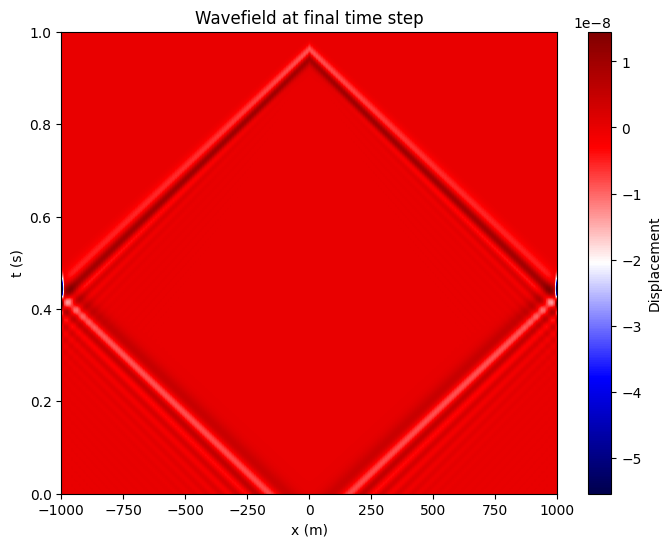

In [2]:
import jax
import jax.numpy as jnp

def ricker_wavelet(t, f0=10.0):
    # A common wavelet in seismology: Ricker wavelet
    # f0: peak frequency
    # t: time array
    # Returns wavelet(t)
    # For demonstration, not explicitly yield-dependent.
    # You might modulate amplitude by yield W if desired.
    a = (jnp.pi * f0 * (t - 1/f0))**2
    return (1.0 - 2.0 * a) * jnp.exp(-a)

def simulate_wave_1d(c=2000.0,
                     rho=2000.0,
                     W=1.0,
                     x_min=-1000.0,
                     x_max=1000.0,
                     dx=10.0,
                     t_max=1.0,
                     dt=0.0005):
    """
    Simulate the wave propagation in 1D using a finite difference approach.

    Parameters
    ----------
    c : float
        Wave speed (m/s)
    rho : float
        Density (kg/m^3)
    W : float
        Yield parameter (scales source amplitude)
    x_min, x_max : float
        Spatial domain limits (meters)
    dx : float
        Spatial step size (meters)
    t_max : float
        Maximum time of simulation (seconds)
    dt : float
        Time step (seconds)

    Returns
    -------
    x : jnp.array
        Spatial grid points.
    t : jnp.array
        Time samples.
    u : jnp.array, shape (n_steps, n_points)
        Wavefield at each time step and space.
    """

    # Create spatial and time grids
    x = jnp.arange(x_min, x_max+dx, dx)
    t = jnp.arange(0, t_max+dt, dt)
    n_x = x.size
    n_t = t.size

    # Identify the index where the source is located (x=0)
    # We pick the grid point closest to x=0.
    src_idx = jnp.argmin(jnp.abs(x))

    # Create the source time function:
    # For demonstration, use a Ricker wavelet modulated by yield W.
    # You could also directly inject something like F(t;W) = W * ricker_wavelet(t).
    F_t = W * ricker_wavelet(t, f0=20.0)  # higher frequency for a sharper pulse

    # Initialize displacement arrays
    # We'll use a second-order scheme in time, so we need u at current and previous time steps.
    u = jnp.zeros((n_t, n_x))
    u_prev = jnp.zeros(n_x)
    u_curr = jnp.zeros(n_x)

    # Coefficients for finite difference
    # Second derivative approximation in space:
    # d²u/dx² ~ (u[i+1] - 2*u[i] + u[i-1]) / dx²
    # We'll implement a function for the spatial second derivative.
    def spatial_second_derivative(u_arr):
        # Use jnp.roll for periodic or zero boundary conditions.
        # Here, assume "fixed" boundary by setting zero displacement at the ends:
        # Alternatively, you could implement absorbing boundaries.
        u_arr = u_arr.at[0].set(0.0)
        u_arr = u_arr.at[-1].set(0.0)
        return (jnp.roll(u_arr, -1) - 2.0*u_arr + jnp.roll(u_arr, 1)) / (dx**2)

    # Time stepping using a central difference scheme:
    # u_{n+1} = 2u_n - u_{n-1} + c² * dt² * d²u/dx² + dt² * (F(t_n)/rho)*δ(x)
    # We'll record every time step in u.
    c2_dt2 = (c**2) * (dt**2)
    factor = dt**2 / rho

    # JIT compile the time stepping for performance
    @jax.jit
    def time_step(u_prev, u_curr, step):
        # Compute spatial second derivative
        d2u_dx2 = spatial_second_derivative(u_curr)
        # Compute source term
        # Inject the source at src_idx
        source_term = factor * F_t[step] * jax.nn.one_hot(src_idx, n_x)
        
        # Update displacement
        u_next = 2*u_curr - u_prev + c2_dt2 * d2u_dx2 + source_term
        return u_curr, u_next

    # Run simulation
    u = u.at[0, :].set(u_curr)
    for i in range(1, n_t):
        u_prev, u_curr = time_step(u_prev, u_curr, i-1)
        u = u.at[i, :].set(u_curr)

    return x, t, u


# Example usage:
x, t, u = simulate_wave_1d()
print("Simulation complete. Shape of u:", u.shape)

import matplotlib.pyplot as plt

# Plot the wavefield at the final time step
plt.figure(figsize=(8, 6))
plt.imshow(u, aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])
plt.colorbar(label='Displacement')
plt.xlabel('x (m)')
plt.ylabel('t (s)')
plt.title('Wavefield at final time step')
plt.show()



In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def display_waveform_gif(x, t, u, filename="waveform.gif", fps=20):
    """
    Create and display an animated GIF of the wavefield evolving over time.

    Parameters
    ----------
    x : jnp.array or np.array
        Spatial coordinates of the simulation.
    t : jnp.array or np.array
        Time steps of the simulation.
    u : jnp.array or np.array, shape (n_time, n_space)
        Wavefield at each time step.
    filename : str
        Filename to save the GIF as.
    fps : int
        Frames per second for the animation.
    """

    fig, ax = plt.subplots(figsize=(8,4))
    line, = ax.plot(x, u[0, :], lw=2)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Displacement')
    ax.set_title('Wave propagation over time')
    ax.grid(True)
    
    # Set a reasonable y-limit to capture wave amplitude
    # This might be adjusted based on simulation scale.
    max_amp = float(jnp.max(jnp.abs(u))) if 'jnp' in str(type(u)) else u.max()
    ax.set_ylim(-1.1*max_amp, 1.1*max_amp)

    def init():
        line.set_data(x, u[0, :])
        return (line,)

    def update(frame):
        line.set_data(x, u[frame, :])
        ax.set_title(f'Wave at t={t[frame]:.4f} s')
        return (line,)
    
    ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True)

    # Save the animation as a GIF
    ani.save(filename, writer='pillow', fps=fps)
    plt.close(fig)  # Close the figure to avoid duplicate display

    # Display the resulting GIF if in a Jupyter environment
    return HTML(f'<img src="{filename}" />')



# Example usage (assuming you have x, t, u from the simulation function):
# from the previous simulation code: x, t, u = simulate_wave_1d()
HTML_obj = display_waveform_gif(x, t, u, filename="waveform.gif", fps=20)
HTML_obj


In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_velocity_profile(x, velocity_model="constant"):
    """
    Return wave speed c(x) depending on the chosen velocity model.

    Parameters
    ----------
    x : jnp.array
        Spatial coordinates.
    velocity_model : str
        The type of velocity model: "constant", "layered", or "marmousi".

    Returns
    -------
    c : jnp.array
        Wave speed at each position x.
    """
    if velocity_model == "constant":
        # Simple homogeneous medium
        c = 2000.0 * jnp.ones_like(x)

    elif velocity_model == "layered":
        # Define layers by position
        # Example: 0 - 0.5 km: 2000 m/s
        #          0.5 - 1.0 km: 2500 m/s
        #          1.0 - 1.5 km: 3000 m/s
        c = jnp.where(x < 500.0, 2000.0,
             jnp.where(x < 1000.0, 2500.0, 3000.0))

    elif velocity_model == "marmousi":
        # For demonstration, let's create a synthetic 1D profile that mimics complexity.
        # A realistic 1D extraction would come from real marmousi data.
        # Here, let's assume a smooth gradient + some sinusoidal variation:
        # Base velocity ~1500 m/s at left boundary and increases to ~3500 m/s at right boundary.
        # Add sinusoidal perturbations to mimic complexity.
        length = x[-1] - x[0]
        norm_x = (x - x[0]) / length  # normalized [0,1]
        base = 1500.0 + 2000.0 * norm_x  # gradient from 1500 to 3500 m/s
        perturbation = 200.0 * jnp.sin(2 * jnp.pi * norm_x * 3) # sinusoidal variation
        c = base + perturbation
    else:
        raise ValueError("Unknown velocity model: choose from 'constant', 'layered', 'marmousi'.")

    return c

def simulate_wave_1d(W=1.0,
                     x_min=0.0,
                     x_max=1500.0,
                     dx=10.0,
                     t_max=1.0,
                     dt=0.0005,
                     velocity_model="constant"):
    """
    Simulate the wave propagation in 1D using a finite difference approach and specified velocity model.

    Parameters
    ----------
    W : float
        Yield parameter (scales source amplitude)
    x_min, x_max : float
        Spatial domain limits (meters)
    dx : float
        Spatial step size (meters)
    t_max : float
        Maximum time of simulation (seconds)
    dt : float
        Time step (seconds)
    velocity_model : str
        Type of velocity model: "constant", "layered", "marmousi"

    Returns
    -------
    x : jnp.array
        Spatial grid points.
    t : jnp.array
        Time samples.
    u : jnp.array, shape (n_steps, n_points)
        Wavefield at each time step and space.
    """
    # Create spatial and time grids
    x = jnp.arange(x_min, x_max+dx, dx)
    t = jnp.arange(0, t_max+dt, dt)
    n_x = x.size
    n_t = t.size

    # Compute velocity profile
    c_profile = get_velocity_profile(x, velocity_model=velocity_model)

    # Identify the source location (at center for simplicity)
    src_idx = jnp.argmin(jnp.abs(x - 0.75e3))  # a source at x=750 m

    # Define a source time function (Ricker wavelet)
    def ricker_wavelet(t, f0=20.0):
        a = (jnp.pi * f0 * (t - 1/f0))**2
        return (1.0 - 2.0 * a) * jnp.exp(-a)

    # Scale by yield
    F_t = W * ricker_wavelet(t, f0=20.0)

    # Initialize displacement arrays
    u = jnp.zeros((n_t, n_x))
    u_prev = jnp.zeros(n_x)
    u_curr = jnp.zeros(n_x)

    # We now have spatially varying c, so c² dt² also varies
    # We'll apply the spatial second derivative and then multiply element-wise.
    # For variable velocity, the wave equation in discrete form is:
    #   u_{n+1}[i] = 2u_{n}[i] - u_{n-1}[i] + dt²/rho * source(i,n) + dt² * (d/dx)(c² d/dx u)
    # Approximate (d/dx)(c² d/dx u) with a finite difference. This becomes more complex because c² is not constant.
    # We'll do:
    # d/dx (c² du/dx) ~ ( (c²[i+1]*(u[i+1]-u[i])/dx) - (c²[i]*(u[i]-u[i-1])/dx) ) / dx
    # = (c²[i+1](u[i+1]-u[i]) - c²[i](u[i]-u[i-1])) / dx²

    # For simplicity, assume density rho=2000 kg/m³ constant (can also be variable if needed)
    rho = 2000.0
    factor = (dt**2) / rho

    def spatial_operator(u_arr, c2):
        # c2 = c_profile²
        # Apply zero displacement at boundary or free boundary condition.
        u_arr = u_arr.at[0].set(0.0)
        u_arr = u_arr.at[-1].set(0.0)

        # Compute finite difference of c² * du/dx:
        # first compute du/dx
        du_dx = (jnp.roll(u_arr, -1) - u_arr) / dx
        c2_du_dx = c2 * du_dx
        # now d/dx of c² du/dx
        d_dx_c2_du_dx = (c2_du_dx - jnp.roll(c2_du_dx, 1)) / dx

        return d_dx_c2_du_dx

    c2 = c_profile**2

    @jax.jit
    def time_step(u_prev, u_curr, step):
        d_dx_c2_du_dx = spatial_operator(u_curr, c2)
        source_term = factor * F_t[step] * jax.nn.one_hot(src_idx, n_x)
        u_next = 2*u_curr - u_prev + dt**2 * d_dx_c2_du_dx + source_term
        return u_curr, u_next

    # Run simulation
    u = u.at[0, :].set(u_curr)
    for i in range(1, n_t):
        u_prev, u_curr = time_step(u_prev, u_curr, i-1)
        u = u.at[i, :].set(u_curr)

    return x, t, u

def display_waveform_gif(x, t, u, filename="waveform.gif", fps=20):
    """
    Create and display an animated GIF of the wavefield evolving over time.

    Parameters
    ----------
    x : jnp.array or np.array
        Spatial coordinates of the simulation.
    t : jnp.array or np.array
        Time steps of the simulation.
    u : jnp.array or np.array, shape (n_time, n_space)
        Wavefield at each time step.
    filename : str
        Filename to save the GIF as.
    fps : int
        Frames per second for the animation.
    """

    # Convert to numpy if needed (for plotting)
    x_ = jnp.array(x)
    t_ = jnp.array(t)
    u_ = jnp.array(u)

    fig, ax = plt.subplots(figsize=(8,4))
    line, = ax.plot(x_, u_[0, :], lw=2)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Displacement')
    ax.set_title('Wave propagation over time')
    ax.grid(True)

    max_amp = float(u_.max())
    min_amp = float(u_.min())
    ax.set_ylim(1.1*min_amp, 1.1*max_amp)

    def init():
        line.set_data(x_, u_[0, :])
        return (line,)

    def update(frame):
        line.set_data(x_, u_[frame, :])
        ax.set_title(f'Wave at t={t_[frame]:.4f} s')
        return (line,)
    
    ani = animation.FuncAnimation(fig, update, frames=len(t_), init_func=init, blit=True)
    ani.save(filename, writer='pillow', fps=fps)
    plt.close(fig)

    return HTML(f'<img src="{filename}" />')

# Example usage:
# x, t, u = simulate_wave_1d(velocity_model="constant")
# display_waveform_gif(x, t, u, filename="constant.gif")

# x, t, u = simulate_wave_1d(velocity_model="layered")
# display_waveform_gif(x, t, u, filename="layered.gif")

x, t, u = simulate_wave_1d(velocity_model="marmousi")
display_waveform_gif(x, t, u, filename="marmousi.gif")


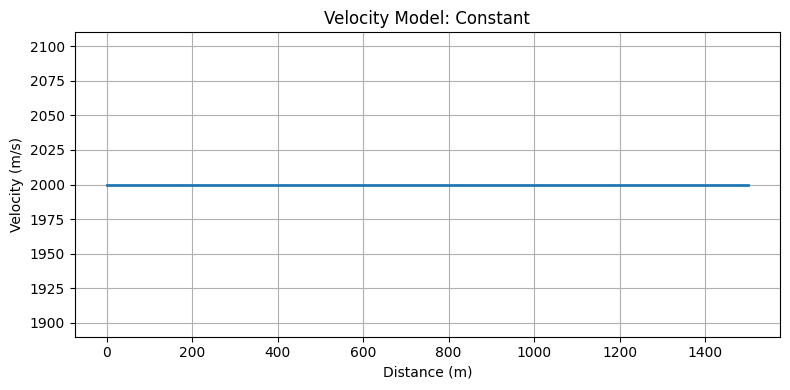

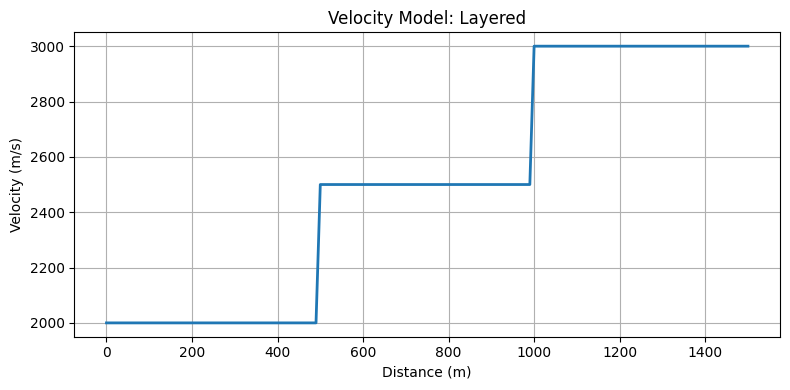

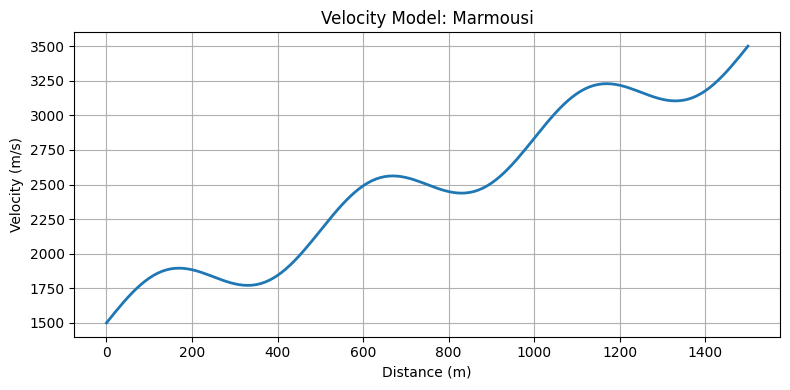

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Velocity Model: Marmousi'}, xlabel='Distance (m)', ylabel='Velocity (m/s)'>)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_velocity_model(x, velocity_model="constant"):
    """
    Plot the velocity model c(x) for a given velocity model type.

    Parameters
    ----------
    x : jnp.array or np.array
        Spatial coordinates.
    velocity_model : str
        The type of velocity model: "constant", "layered", or "marmousi".

    Returns
    -------
    fig, ax : matplotlib figure and axes
        The figure and axes objects of the plot.
    """
    # Convert x to numpy for plotting if necessary
    x_ = x if isinstance(x, np.ndarray) else jnp.array(x)
    if 'jnp' in str(type(x_)):
        x_ = np.array(x_)

    c = get_velocity_profile(x, velocity_model)

    # Convert to numpy if c is a DeviceArray
    if 'jnp' in str(type(c)):
        c = np.array(c)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(x_, c, lw=2)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Velocity (m/s)')
    ax.set_title(f'Velocity Model: {velocity_model.capitalize()}')
    ax.grid(True)

    plt.tight_layout()
    plt.show()
    return fig, ax

# Example usage:
x = jnp.arange(0, 1500+10, 10)
plot_velocity_model(x, velocity_model="constant")
plot_velocity_model(x, velocity_model="layered")
plot_velocity_model(x, velocity_model="marmousi")


/tmp/ipykernel_975/4192681139.py:133: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])
/tmp/ipykernel_975/4192681139.py:133: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])


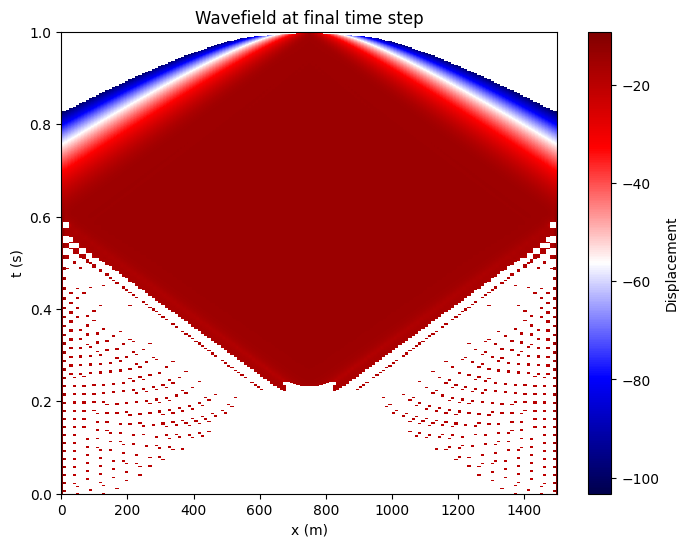

In [12]:
import jax
import jax.numpy as jnp
import numpy as np

def compute_material_params():
    # Placeholder: return lambda, mu, rho, C
    # In reality, these should be determined from the medium properties
    rho = 2000.0      # density in kg/m^3
    C = 2000.0        # P-wave speed in m/s
    # Relationship between lambda and mu depends on Poisson's ratio and Young's modulus
    # For simplicity, assume a Poisson's ratio ~0.25 and a given mu.
    mu = 30e9          # Shear modulus in Pa (example)
    # lambda = K - 2/3 mu, where K is bulk modulus, or chosen for demonstration:
    # Let's pick lambda = 2*mu (just a placeholder)
    lambda_ = 60e9
    return lambda_, mu, rho, C

def compute_elastic_radius_and_fc(W, DOB, rho, C):
    # Placeholder: Use scaling relations from Stevens & Day (1985) or other references.
    # For demonstration, pick a simple scaling:
    # R_el ~ k * W^{1/3}, f_c ~ C/R_el
    # These are not correct formulas, just placeholders.
    R_el = 50.0  # meters, a stand-in example
    f_c = C / R_el
    return R_el, f_c

def compute_pressures_and_gamma(W, DOB, C):
    # P_o, P_2, gamma depend on the source phenomenology.
    # Refer to Saikia (2017), Mueller & Murphy (1971), and Stevens & Day (1985).
    # Placeholder constants:
    P1 = 1e9  # peak shock pressure (Pa), just an example
    P2 = 1e8  # steady-state pressure (Pa)
    gamma = 50.0 # decay parameter in 1/s
    # P_o and P_2(t) can be from P1, P2:
    # As per eqn in manuscript:
    # P(t) = [P_o exp(-gamma t) + P_2] H(t)
    # Here we just set P_o = P1 - P2 for demonstration:
    P_o = P1 - P2
    return P_o, P2, gamma

def nuclear_tdsf(t, W, DOB):
    lambda_, mu, rho, C = compute_material_params()
    R_el, f_c = compute_elastic_radius_and_fc(W, DOB, rho, C)
    P_o, P2, gamma = compute_pressures_and_gamma(W, DOB, C)
    
    # Compute parameters alpha, beta, p:
    beta = (lambda_ + 2*mu) / (4*mu)
    omega_0 = C / R_el
    # compute p:
    # p = sqrt((omega_0^2/(2 beta)) - (omega_0^2/(4 beta^2)))
    # Factor out omega_0^2:
    inside = (omega_0**2/(2*beta)) - (omega_0**2/(4*beta**2))
    p = jnp.sqrt(inside)
    alpha = omega_0/(2*beta)

    # Compute F(t):
    # F(t) = [(R_el/(4 mu))*(C^2/(beta p))] * H(t)*exp(-alpha t)*sin(p t)
    # Heaviside step:
    Ht = jnp.where(t >= 0, 1.0, 0.0)
    F_t = (R_el/(4*mu))*(C**2/(beta*p))*Ht*jnp.exp(-alpha*t)*jnp.sin(p*t)

    # Compute S(t):
    # S(t) = [F(t)/R_el^2 + F'(t)/(R_el*C)] * [ (e^{-gamma t}P_o + P2)*H(t) ]
    dF_dt = jax.grad(lambda tau: F_t[jnp.argmin(jnp.abs(tau-t))]) # We'll vectorize below.
    # Actually, let's differentiate w.r.t. t using jax.vmap for efficiency:
    # But we can analytically compute derivative:
    # dF/dt = ... But for simplicity let's use JAX autodiff:

    # For JAX differentiation, we must ensure t is a scalar. If t is array, we do vmap:
    def F_scalar(tau):
        return (R_el/(4*mu))*(C**2/(beta*p))*jnp.heaviside(tau,0)*jnp.exp(-alpha*tau)*jnp.sin(p*tau)

    dF = jax.vmap(jax.grad(F_scalar))(t)

    source_amplitude = (F_t/(R_el**2) + dF/(R_el*C)) * ((jnp.exp(-gamma*t)*P_o + P2)*Ht)

    return source_amplitude

def simulate_wave_1d_with_tdsf(W=1.0, DOB=200.0,
                              x_min=0.0, x_max=1500.0, dx=10.0,
                              t_max=1.0, dt=0.0005):
    # Example simulation using PDE solver from previous code:
    x = jnp.arange(x_min, x_max+dx, dx)
    t = jnp.arange(0, t_max+dt, dt)
    n_x = x.size
    n_t = t.size
    
    # Retrieve material params and set up PDE as before
    lambda_, mu, rho, C = compute_material_params()
    c_profile = C * jnp.ones_like(x)  # constant for simplicity
    c2 = c_profile**2

    # Source index:
    src_idx = jnp.argmin(jnp.abs(x - 750.0))

    # Compute the nuclear TDSF at all time steps:
    source_time_function = nuclear_tdsf(t, W, DOB)

    u = jnp.zeros((n_t, n_x))
    u_prev = jnp.zeros(n_x)
    u_curr = jnp.zeros(n_x)

    factor = (dt**2) / rho

    def spatial_operator(u_arr, c2):
        u_arr = u_arr.at[0].set(0.0)
        u_arr = u_arr.at[-1].set(0.0)
        du_dx = (jnp.roll(u_arr, -1) - u_arr)/dx
        c2_du_dx = c2 * du_dx
        d_dx_c2_du_dx = (c2_du_dx - jnp.roll(c2_du_dx, 1))/dx
        return d_dx_c2_du_dx

    @jax.jit
    def time_step(u_prev, u_curr, step):
        d_dx_c2_du_dx = spatial_operator(u_curr, c2)
        source_term = factor * source_time_function[step] * jax.nn.one_hot(src_idx, n_x)
        u_next = 2*u_curr - u_prev + dt**2*d_dx_c2_du_dx + source_term
        return u_curr, u_next

    u = u.at[0,:].set(u_curr)
    for i in range(1, n_t):
        u_prev, u_curr = time_step(u_prev, u_curr, i-1)
        u = u.at[i,:].set(u_curr)

    return x, t, u

# Example usage:
x, t, u = simulate_wave_1d_with_tdsf(W=0.001, DOB=200)


# Plot the wavefield at the final time step
plt.figure(figsize=(8, 6))
plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])
plt.colorbar(label='Displacement')
plt.xlabel('x (m)')
plt.ylabel('t (s)')
plt.title('Wavefield at final time step')
plt.show()


In [14]:
import jax
import jax.numpy as jnp

def granite_parameters():
    """
    Returns material and empirical constants for granite.
    """
    # From Table and known constants for granite (Stevens & Day 1985, Saikia 2017)
    rho = 2550.0          # kg/m^3 (Granite)
    C_p = 5500.0          # P-wave speed in m/s
    C_s = 3175.0          # S-wave speed in m/s
    # Compute Lamé parameters
    mu = rho * C_s**2
    lambda_ = rho * C_p**2 - 2*mu
    
    # Empirical constants for granite:
    h_o = 122.0     # m
    R_o = 321.0     # m
    gamma_o = 34.0  # 1/s
    P10 = 4.6e6     # Pa (4.6 MPa)
    P20 = 2.4e6     # Pa (2.4 MPa)
    n = 2.4
    
    return rho, lambda_, mu, C_p, h_o, R_o, gamma_o, P10, P20, n

def compute_tdsf_parameters(W, h, rho, lambda_, mu, C, h_o, R_o, gamma_o, P10, P20, n):
    """
    Compute parameters P1, P2, gamma, alpha, p for the TDSF.
    W in kt, h in m.
    """
    # Compute P1, P2, gamma
    P1 = P10 * (h/h_o)
    exponent = (n - 9)/(3*n)
    P2 = P20 * (h_o/h)**exponent * W**(-0.13)
    gamma = gamma_o * (h/h_o)**(1/n) * W**(-1/3)
    
    # Compute beta:
    beta = jnp.sqrt((lambda_ + 2*mu)/(4*mu))
    
    # Compute omega_0:
    omega_0 = (C/R_o)*((h/h_o)**(1/n))*W**(-1/3)
    alpha = omega_0/(2*beta)
    p = omega_0*jnp.sqrt((1/beta) - (1/(4*beta**2)))
    
    return P1, P2, gamma, alpha, p, beta

def A_t(t, C, mu, beta, p, alpha):
    """
    Compute A(t) = (C/(4 mu beta))*(1/p)*d/dt[e^{-alpha t} sin(p t)].
    """
    # derivative inside:
    # d/dt [e^{-alpha t} sin(p t)] = e^{-alpha t}(p cos(pt) - alpha sin(pt))
    # Let's do it explicitly:
    return (C/(4*mu*beta))*(1/p)*(jnp.exp(-alpha*t)*(p*jnp.cos(p*t) - alpha*jnp.sin(p*t)))

def B_t(t, P1, P2, gamma):
    """
    B(t) = e^{-gamma t}(P1 - P2) + P2
    """
    return jnp.exp(-gamma*t)*(P1 - P2) + P2

def source_time_function(t, W, h):
    """
    Construct the TDSF S(t) by convolving A(t) and B(t).
    For simplicity, do discrete convolution.
    """
    rho, lambda_, mu, C, h_o, R_o, gamma_o, P10, P20, n = granite_parameters()
    P1, P2, gamma, alpha, p, beta = compute_tdsf_parameters(W, h, rho, lambda_, mu, C, h_o, R_o, gamma_o, P10, P20, n)
    
    # Compute A and B over time array
    A = A_t(t, C, mu, beta, p, alpha)
    B = B_t(t, P1, P2, gamma)
    
    # Convolution S = A * B (discrete convolution with dt assumed uniform)
    # Use 'full' and then truncate to length of t or just 'same':
    dt = t[1]-t[0]
    # Discrete convolution:
    S = jnp.convolve(A, B, mode='full')*dt
    # Truncate to size of t array (assuming causal from 0):
    S = S[:t.size]
    return S, rho

def simulate_wave_1d(W=1.0, h=200.0, x_min=-1000.0, x_max=1000.0, dx=10.0, t_max=1.0, dt=0.0005):
    """
    Simulate the 1D wave propagation with TDSF source for given W and h.
    """
    x = jnp.arange(x_min, x_max+dx, dx)
    t = jnp.arange(0, t_max+dt, dt)
    n_x = x.size
    n_t = t.size
    
    S, rho = source_time_function(t, W, h)
    
    # Wave speed (constant granite):
    # We have C from granite_parameters():
    rho_, lambda_, mu, C, _, _, _, _, _, _ = granite_parameters()
    c2 = C**2*jnp.ones_like(x)
    
    # FD scheme arrays
    u = jnp.zeros((n_t, n_x))
    u_prev = jnp.zeros(n_x)
    u_curr = jnp.zeros(n_x)

    factor = (dt**2)/rho
    src_idx = jnp.argmin(jnp.abs(x))
    
    def spatial_operator(u_arr, c2):
        # second derivative in space using central difference
        u_arr = u_arr.at[0].set(0.0)
        u_arr = u_arr.at[-1].set(0.0)
        return (jnp.roll(u_arr, -1) - 2.0*u_arr + jnp.roll(u_arr, 1))/dx**2
    
    @jax.jit
    def time_step(u_prev, u_curr, step):
        d2u_dx2 = spatial_operator(u_curr, c2)
        source_term = factor * S[step] * jax.nn.one_hot(src_idx, n_x)
        u_next = 2*u_curr - u_prev + (C**2 * dt**2)*d2u_dx2 + source_term
        return u_curr, u_next
    
    u = u.at[0,:].set(u_curr)
    for i in range(1, n_t):
        u_prev, u_curr = time_step(u_prev, u_curr, i-1)
        u = u.at[i,:].set(u_curr)

    return x, t, u

# Example usage:
x, t, u = simulate_wave_1d(W=1.0, h=200.0)
# The array u will contain the displacement wavefield for each time and space point.


/tmp/ipykernel_975/347755603.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])
/tmp/ipykernel_975/347755603.py:3: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])


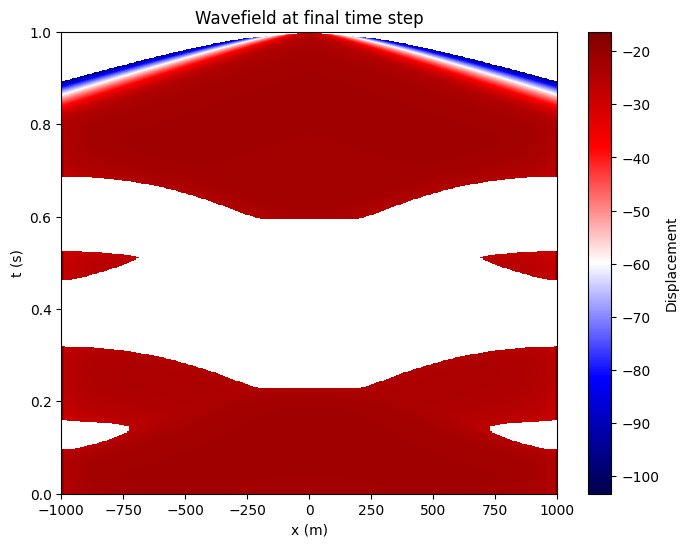

In [15]:

# Plot the wavefield at the final time step
plt.figure(figsize=(8, 6))
plt.imshow(np.log(u), aspect='auto', cmap='seismic', extent=[x.min(), x.max(), t.min(), t.max()])
plt.colorbar(label='Displacement')
plt.xlabel('x (m)')
plt.ylabel('t (s)')
plt.title('Wavefield at final time step')
plt.show()


In [16]:
HTML_obj = display_waveform_gif(x, t, u, filename="waveform.gif", fps=20)
HTML_obj

In [19]:
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jit
import functools

# ==========================================================
# Constants and material parameters (example: Tuff/Rhyolite)
# Adjust based on desired medium from Table 1
# ==========================================================
h0 = 122.0   # meters
R0 = 202.0   # meters
gamma0 = 26.0  # 1/sec
P1o = 3.6      # MPa
P2o = 5.0      # MPa
n = 2.4
C = 3500.0     # P-wave velocity (m/s)
# S-vel, Density, lambda, mu (not directly provided but can be computed)
S = 2021.0     # S-wave velocity
rho = 2000.0   # Density kg/m^3

# Compute Lame parameters lambda and mu from P and S velocities
# Vp = sqrt((lambda+2mu)/rho), Vs=sqrt(mu/rho)
mu = rho * (S**2)
lam = rho*(C**2 - 2*(S**2))

# beta definition: beta = sqrt((lambda+2mu)/(4mu))
beta = jnp.sqrt((lam + 2.0*mu) / (4.0*mu))

# Time sampling
dt = 0.01  # sampling interval in seconds
nt = 2000  # number of samples
t = jnp.arange(nt)*dt

# Distance r: assume a receiver at distance r from source
r = 10000.0  # 10 km for example

# ==========================================================
# Define helper functions
# ==========================================================

def omega0(h, W):
    # omega_o = (C/R0)* (h/h0)^{1/n} * W^{-1/3}
    return (C/R0) * (h/h0)**(1.0/n) * W**(-1.0/3)

def alpha(h, W):
    # alpha = omega0/(2*beta)
    return omega0(h, W)/(2.0*beta)

def p(h, W):
    # p = omega0 * sqrt(1/beta - 1/(4*beta^2))
    return omega0(h, W)*jnp.sqrt((1.0/beta) - 1.0/(4.0*beta**2))

def gamma(h, W):
    # gamma = gamma0 * (h/h0)^{1/n} * W^{-1/3}
    return gamma0 * (h/h0)**(1.0/n) * W**(-1.0/3)

def P1(h):
    # P1 = P1o * (h/h0)
    return P1o*(h/h0)

def P2(h,W):
    # P2 = P2o * (h0/h)^{(n-9)/(3n)} * W^{-0.13}
    return P2o*(h0/h)**((n-9.0)/(3.0*n)) * W**(-0.13)

# ==========================================================
# Define A(t,h,W), B(t,h,W) per Eq. (IV-4)
# ==========================================================

def A_time(h,W):
    # A(t) = [C/(4*mu*beta)]*(1/p)* e^{-alpha t} sin(p t) differentiated wrt t
    # Actually A(t) given in eq. (IV-4) includes a time derivative:
    # A(t) = [C/(4 mu beta)][1/p] e^{-alpha t} sin(p t)
    # We'll just form that time series directly.
    alp = alpha(h,W)
    pp = p(h,W)
    prefactor = (C/(4.0*mu*beta))*(1.0/pp)
    # A(t):
    return prefactor * jnp.exp(-alp*t)*jnp.sin(pp*t)

def B_time(h,W):
    # B(t) = e^{-gamma t}(P1 - P2) + P2
    ga = gamma(h,W)
    return jnp.exp(-ga*t)*(P1(h)-P2(h,W)) + P2(h,W)

# ==========================================================
# Green's function G(t,h,r)
# For simplicity, we use a simple Ricker wavelet or a known Green's function.
# In actual scenarios, G would be computed from a wave propagation code.
# Here we just simulate G as a delta or a simple wavelet.
def G_time(h,r):
    # Simple approximation: a delta-like Green’s function
    # In reality, G depends on h, r, and earth structure.
    # Here we just return a simple function that does not vary much.
    # Example: A simple low-frequency wavelet centered at t=1.0s
    f0 = 1.0
    t0 = 1.0
    return jnp.exp(-((t - t0)**2 * f0**2))  # Gaussian wavelet as a placeholder

# ==========================================================
# Convolution helper
# JAX does not have a direct 'full' convolution in jax.numpy.convolve.
# We can implement using 'same' or pad as needed.
# We'll use 'full' and then truncate to length nt for simplicity.
# ==========================================================
def convolve(u,v):
    # full convolution
    w = jnp.convolve(u,v,mode='full')
    # truncate to length of t (assuming causality and zero-padding)
    return w[:nt]

# ==========================================================
# Forward model: U(t,h,W,r) = A * B * G
# We will convolve in sequence: S = A * B, then U = S * G
# ==========================================================
def forward(h,W,r):
    A_ = A_time(h,W)
    B_ = B_time(h,W)
    G_ = G_time(h,r)
    # Convolve A and B
    AB = convolve(A_, B_)
    # Convolve result with G
    U = convolve(AB, G_)
    return U

# ==========================================================
# Synthetic observed data
# Let's choose true h and W
# ==========================================================
h_true = 800.0
W_true = 500.0  # Kt
obs = forward(h_true,W_true,r)

# Add some noise to simulate realistic scenario
noise_level = 0.01
obs_noisy = obs 
# + noise_level*jnp.random.normal(key=jax.random.PRNGKey(0), shape=(nt,))

# ==========================================================
# Inversion setup:
# We want to minimize the L2 misfit: ||U(h,W)-obs||^2
# ==========================================================
def misfit(h,W):
    pred = forward(h,W,r)
    return jnp.sum((pred - obs_noisy)**2)

# Gradients wrt h and W
grad_misfit = jax.grad(lambda params: misfit(params[0], params[1]))

# ==========================================================
# Simple gradient-based inversion
# ==========================================================
h_est = 1000.0  # initial guess for depth
W_est = 400.0   # initial guess for yield
params = jnp.array([h_est, W_est])

learning_rate = 1e-5
niter = 1000

for i in range(niter):
    g = grad_misfit(params)
    params = params - learning_rate*g
    if i % 200 == 0:
        current_misfit = misfit(params[0], params[1])
        print(f"Iter {i}, h={params[0]:.2f} m, W={params[1]:.2f} Kt, misfit={current_misfit:.2e}")

h_inv, W_inv = params
print("True values: h={}, W={}".format(h_true, W_true))
print("Inverted values: h={:.2f}, W={:.2f}".format(h_inv, W_inv))


Iter 0, h=1000.00 m, W=400.00 Kt, misfit=1.58e-05
Iter 200, h=1000.00 m, W=400.00 Kt, misfit=1.58e-05
Iter 400, h=1000.00 m, W=400.00 Kt, misfit=1.58e-05
Iter 600, h=1000.00 m, W=400.00 Kt, misfit=1.58e-05
Iter 800, h=1000.00 m, W=400.00 Kt, misfit=1.58e-05
True values: h=800.0, W=500.0
Inverted values: h=1000.00, W=400.00


In [20]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from functools import partial

# ==========================================================
# Constants and parameters (as before)
# Adjust as needed
# ==========================================================
h0 = 122.0
R0 = 202.0
gamma0 = 26.0
P1o = 3.6
P2o = 5.0
n = 2.4
C = 3500.0
S = 2021.0
rho = 2000.0
mu = rho*(S**2)
lam = rho*(C**2 - 2*(S**2))
beta = jnp.sqrt((lam+2*mu)/(4*mu))

dt = 0.01
nt = 2000
t = jnp.arange(nt)*dt
r = 10000.0

# True parameters for synthetic data
h_true = 800.0
W_true = 500.0

# ==========================================================
# Define forward model components
# ==========================================================
def omega0(h, W):
    return (C/R0) * (h/h0)**(1/n) * W**(-1/3)

def alpha(h, W):
    return omega0(h,W)/(2*beta)

def p(h, W):
    return omega0(h,W)*jnp.sqrt(1.0/beta - 1.0/(4.0*beta**2))

def gamma(h,W):
    return gamma0*(h/h0)**(1/n)*W**(-1/3)

def P1(h):
    return P1o*(h/h0)

def P2(h,W):
    return P2o*(h0/h)**((n-9)/(3*n))*W**(-0.13)

def A_time(h,W,t):
    prefactor = (C/(4*mu*beta))*(1.0/p(h,W))
    return prefactor * jnp.exp(-alpha(h,W)*t)*jnp.sin(p(h,W)*t)

def B_time(h,W,t):
    return jnp.exp(-gamma(h,W)*t)*(P1(h)-P2(h,W)) + P2(h,W)

def G_time(h,r,t):
    # Placeholder Green's function (simple Gaussian)
    f0 = 1.0
    t0 = 1.0
    return jnp.exp(-((t - t0)**2 * f0**2))

def convolve(u,v):
    w = jnp.convolve(u,v,mode='full')
    return w[:nt]

def forward(h,W,r,t):
    A_ = A_time(h,W,t)
    B_ = B_time(h,W,t)
    G_ = G_time(h,r,t)
    AB = convolve(A_, B_)
    U = convolve(AB, G_)
    return U

# Synthetic observed data
obs = forward(h_true, W_true, r, t)
noise_level = 0.01
key = random.PRNGKey(0)
obs_noisy = obs + noise_level * random.normal(key, shape=(nt,))

# ==========================================================
# PINN Setup
# ==========================================================

# Neural network to represent U(t). h and W will be parameters too.
# Let's define a small MLP:
def init_mlp_params(key, sizes):
    params = []
    keys = random.split(key, len(sizes))
    for i in range(len(sizes)-1):
        k_w, k_b = random.split(keys[i])
        W = random.normal(k_w, (sizes[i], sizes[i+1]))*jnp.sqrt(2.0/sizes[i])
        b = jnp.zeros((sizes[i+1],))
        params.append((W,b))
    return params

def mlp(params, x):
    # Forward pass
    for (W,b) in params[:-1]:
        x = jnp.tanh(x@W + b)
    W,b = params[-1]
    return (x @ W + b).reshape(-1)

# MLP architecture
layer_sizes = [1,64,64,64,1]
mlp_key = random.PRNGKey(42)
params_mlp = init_mlp_params(mlp_key, layer_sizes)

# Treat h and W as trainable parameters (log-parameterization to keep positive)
log_h = jnp.log(900.0) # initial guess h=900m
log_W = jnp.log(400.0) # initial guess W=400kt

all_params = (params_mlp, log_h, log_W)

# Physics-informed loss:
# We have two terms:
# 1) Data misfit: ||U_nn(t) - U_obs(t)||^2
# 2) Physics residual: U_nn(t) should match forward(h,W) computed from A,B,G
#    We could also enforce directly U_nn(t) ~ forward(h,W) as a "physics" constraint.
# In a more classical PINN setup, you'd have PDE residuals. Here we use the known forward model as a proxy.

def loss_fn(all_params, t, obs):
    params_mlp, log_h, log_W = all_params
    h_ = jnp.exp(log_h)
    W_ = jnp.exp(log_W)

    U_pred = mlp(params_mlp, t.reshape(-1,1))  # Neural net approx of U(t)
    # Physics target from known forward model:
    U_phys = forward(h_, W_, r, t)
    
    # Data misfit
    data_loss = jnp.mean((U_pred - obs)**2)
    # Physics loss: enforce NN solution matches the physics solution
    phys_loss = jnp.mean((U_pred - U_phys)**2)

    # Combined loss
    # In a true PINN, you might also add PDE residual terms. Here we enforce known forward relation:
    return data_loss + phys_loss

grad_fn = jax.grad(loss_fn)

# ==========================================================
# Training loop
# ==========================================================
learning_rate = 1e-4
niter = 2000

for i in range(niter):
    grads = grad_fn(all_params, t, obs_noisy)
    params_mlp, log_h, log_W = all_params
    params_mlp_grads, log_h_grad, log_W_grad = grads

    # Update mlp params
    new_params_mlp = []
    for (W,b),(dW,db) in zip(params_mlp, params_mlp_grads):
        new_params_mlp.append((W - learning_rate*dW, b - learning_rate*db))

    # Update h, W parameters
    new_log_h = log_h - learning_rate * log_h_grad
    new_log_W = log_W - learning_rate * log_W_grad

    all_params = (new_params_mlp, new_log_h, new_log_W)

    if i % 200 == 0:
        current_loss = loss_fn(all_params, t, obs_noisy)
        h_est = jnp.exp(all_params[1])
        W_est = jnp.exp(all_params[2])
        print(f"Iter {i}, Loss={current_loss:.4e}, h={h_est:.2f}, W={W_est:.2f}")

h_inv = jnp.exp(all_params[1])
W_inv = jnp.exp(all_params[2])
print("True values: h={}, W={}".format(h_true, W_true))
print("Inverted values via PINN: h={:.2f}, W={:.2f}".format(h_inv, W_inv))


Iter 0, Loss=7.4373e-01, h=900.00, W=400.00
Iter 200, Loss=1.1015e-02, h=900.00, W=400.00
Iter 400, Loss=8.1142e-03, h=900.00, W=400.00
Iter 600, Loss=6.1220e-03, h=900.00, W=400.00
Iter 800, Loss=4.6628e-03, h=900.00, W=400.00
Iter 1000, Loss=3.6349e-03, h=900.00, W=400.00
Iter 1200, Loss=2.9015e-03, h=900.00, W=400.00
Iter 1400, Loss=2.3520e-03, h=900.00, W=400.00
Iter 1600, Loss=1.9592e-03, h=900.00, W=400.00
Iter 1800, Loss=1.6633e-03, h=900.00, W=400.00
True values: h=800.0, W=500.0
Inverted values via PINN: h=900.00, W=400.00


In [18]:
jnp.random.normal(key=jax.random.PRNGKey(0), shape=(nt,))

AttributeError: module 'jax.numpy' has no attribute 'random'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# NN implementation
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(NN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# KAN layer  
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# State-Space Model Implementation
class StateSpaceModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kan_layers):
        super(StateSpaceModel, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the KANs for state transition and observation
        self.kan_state_transition = KAN([state_dim + input_dim] + kan_layers + [state_dim])
        self.kan_observation = KAN([state_dim + input_dim] + kan_layers + [output_dim])

    def forward(self, state, input, update_grid=False):
        # State transition: x_{t+1} = f(x_t, u_t)
        state_input = torch.cat([state, input], dim=-1)
        next_state = self.kan_state_transition(state_input, update_grid=update_grid)

        # Observation: y_t = g(x_t, u_t)
        observation = self.kan_observation(state_input, update_grid=update_grid)

        return next_state, observation

# Example Usage
state_dim = 4
input_dim = 2
output_dim = 3
kan_layers = [64, 64]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 10
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

# Forward pass
next_state, observation = model(state, input)

print("Next State:", next_state)
print("Observation:", observation)

# Training Loop (Simplified)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):
    optimizer.zero_grad()
    
    next_state, observation = model(state, input)
    loss = criterion(next_state, state) + criterion(observation, observation_target)
    
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Next State: tensor([[-0.0653,  0.0173,  0.0040, -0.0057],
        [-0.0409, -0.0038,  0.0046,  0.0140],
        [-0.0129,  0.0134, -0.0058,  0.0031],
        [ 0.0167,  0.0069,  0.0088, -0.0329],
        [-0.0366, -0.0148,  0.0259,  0.0451],
        [ 0.0222,  0.0306,  0.0283, -0.0252],
        [-0.0141,  0.0094, -0.0066, -0.0186],
        [ 0.0419,  0.0128,  0.0742, -0.0490],
        [ 0.0208,  0.0104,  0.0166, -0.0179],
        [-0.0739, -0.0104,  0.0055,  0.0355]], grad_fn=<ViewBackward0>)
Observation: tensor([[ 0.0052,  0.0006, -0.0180],
        [-0.0038,  0.0380,  0.0094],
        [-0.0224,  0.0015, -0.0018],
        [ 0.0073, -0.0149, -0.0171],
        [ 0.0601,  0.0722, -0.0114],
        [-0.0263,  0.0173,  0.0025],
        [-0.0042, -0.0176, -0.0143],
        [ 0.0231,  0.0407, -0.0082],
        [ 0.0011, -0.0023,  0.0034],
        [ 0.0190,  0.0296,  0.0023]], grad_fn=<ViewBackward0>)


/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Loss: 2.728789806365967
Epoch 2, Loss: 2.694186210632324
Epoch 3, Loss: 2.6600122451782227
Epoch 4, Loss: 2.626150608062744
Epoch 5, Loss: 2.592484951019287
Epoch 6, Loss: 2.558899164199829
Epoch 7, Loss: 2.525275945663452
Epoch 8, Loss: 2.491499662399292
Epoch 9, Loss: 2.457456111907959
Epoch 10, Loss: 2.4230363368988037
Epoch 11, Loss: 2.3881375789642334
Epoch 12, Loss: 2.352665424346924
Epoch 13, Loss: 2.3165359497070312
Epoch 14, Loss: 2.2796740531921387
Epoch 15, Loss: 2.2420167922973633
Epoch 16, Loss: 2.2035107612609863
Epoch 17, Loss: 2.164112091064453
Epoch 18, Loss: 2.123788356781006
Epoch 19, Loss: 2.082516670227051
Epoch 20, Loss: 2.0402865409851074
Epoch 21, Loss: 1.9970996379852295
Epoch 22, Loss: 1.9529697895050049
Epoch 23, Loss: 1.9079253673553467
Epoch 24, Loss: 1.8620095252990723
Epoch 25, Loss: 1.8152787685394287
Epoch 26, Loss: 1.767806053161621
Epoch 27, Loss: 1.7196803092956543
Epoch 28, Loss: 1.6710057258605957
Epoch 29, Loss: 1.6219007968902588
Epoch 3

In [3]:
from torchinfo import summary
summary(model, input_size=[(batch_size, state_dim), (batch_size, input_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [10, 4]                   --
├─KAN: 1-1                               [10, 4]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [10, 64]                  3,840
│    │    └─KANLinear: 3-2               [10, 64]                  40,960
│    │    └─KANLinear: 3-3               [10, 4]                   2,560
├─KAN: 1-2                               [10, 3]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [10, 64]                  3,840
│    │    └─KANLinear: 3-5               [10, 64]                  40,960
│    │    └─KANLinear: 3-6               [10, 3]                   1,920
Total params: 94,080
Trainable params: 94,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pas

# Cosine

Epoch 10, Loss: 0.7876420021057129
Epoch 20, Loss: 0.095182403922081
Epoch 30, Loss: 0.042838044464588165
Epoch 40, Loss: 0.014251034706830978
Epoch 50, Loss: 0.005281991790980101
Epoch 60, Loss: 0.0031826170161366463
Epoch 70, Loss: 0.001111673889681697
Epoch 80, Loss: 0.0008761516073718667
Epoch 90, Loss: 0.0006899439031258225
Epoch 100, Loss: 0.0005782707594335079
Epoch 110, Loss: 0.0005608103820122778
Epoch 120, Loss: 0.0005172466626390815
Epoch 130, Loss: 0.0004962254897691309
Epoch 140, Loss: 0.00047108787111938
Epoch 150, Loss: 0.00044747511856257915
Epoch 160, Loss: 0.0004245440650265664
Epoch 170, Loss: 0.0004016944149043411
Epoch 180, Loss: 0.000379279867047444
Epoch 190, Loss: 0.0003572914865799248
Epoch 200, Loss: 0.0003357758105266839


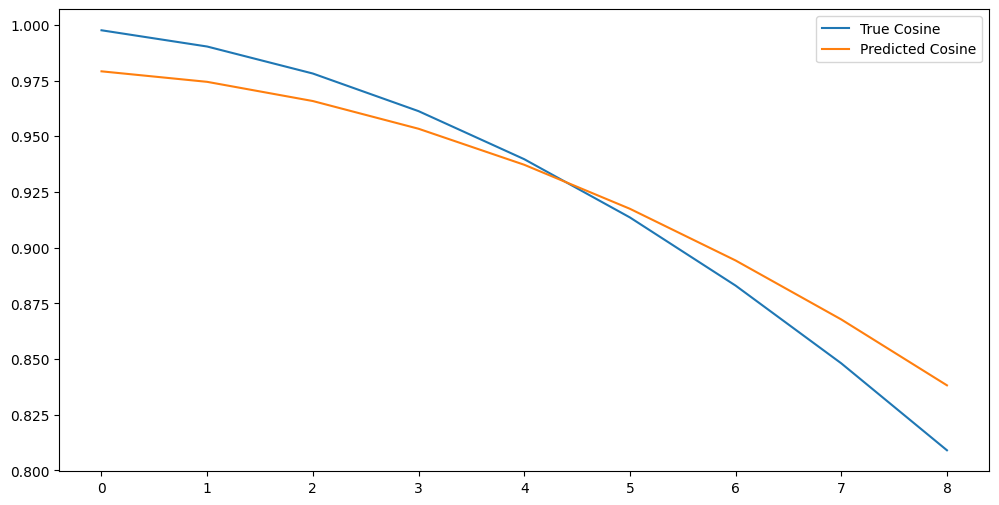

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Example Usage for Cosine Function Extrapolation
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Create a dataset for the cosine function
def generate_cosine_data(seq_length, num_sequences):
    x = torch.linspace(0, 2 * math.pi/10, seq_length)
    data = torch.cos(x).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences

seq_length = 10
num_sequences = 10
data = generate_cosine_data(seq_length, num_sequences)

# Split into train and test sets
train_size = int(0.8 * num_sequences)
test_size = num_sequences - train_size

train_data = data[:train_size]
test_data = data[train_size:]

# Training Loop (Simplified)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    state = train_data[:, :-1, :]  # All but the last value as state
    input = train_data[:, 1:, :]  # All but the first value as input (next state)
    observation_target = train_data[:, 1:, :]  # Target is the next value
    
    state = state.reshape(-1, state_dim)
    input = input.reshape(-1, input_dim)
    observation_target = observation_target.reshape(-1, output_dim)
    
    next_state, observation = model(state, input)
    loss = criterion(next_state, state) + criterion(observation, observation_target)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Extrapolation on Test Data
model.eval()
with torch.no_grad():
    test_state = test_data[:, :-1, :]
    test_input = test_data[:, 1:, :]
    
    test_state = test_state.reshape(-1, state_dim)
    test_input = test_input.reshape(-1, input_dim)
    
    _, test_observation = model(test_state, test_input)
    
    # Reshape for plotting
    test_observation = test_observation.view(test_size, seq_length - 1, output_dim).squeeze(-1)
    test_target = test_data[:, 1:, :].squeeze(-1)

# Plot the extrapolation results
plt.figure(figsize=(12, 6))
plt.plot(test_target[0].cpu().numpy(), label="True Cosine")
plt.plot(test_observation[0].cpu().numpy(), label="Predicted Cosine")
plt.legend()
plt.show()


Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 10, Train Loss: 8.420e-01, Test Loss: 3.419e-01, Extrapolation Loss: 2.571e-01
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 20, Train Loss: 1.006e-01, Test Loss: 2.155e-02, Extrapolation Loss: 1.007e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 30, Train Loss: 4.119e-02, Test Loss: 2.628e-02, Extrapolation Loss: 3.555e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 40, Train Loss: 1.676e-02, Test Loss: 4.267e-03, Extrapolation Loss: 9.862e-03
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 50, Train Loss: 3.901e-03, Test Loss: 2.542e-03, Extrapolation Loss: 1.938e-04
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 60, Train Loss: 3.309e-03, Test Loss: 1.119e-03, Extrapolation Loss: 2.195e-04
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 70, Train Loss: 4.340e-04, Test Loss: 3.156e-04, Extrapolation Loss: 2.

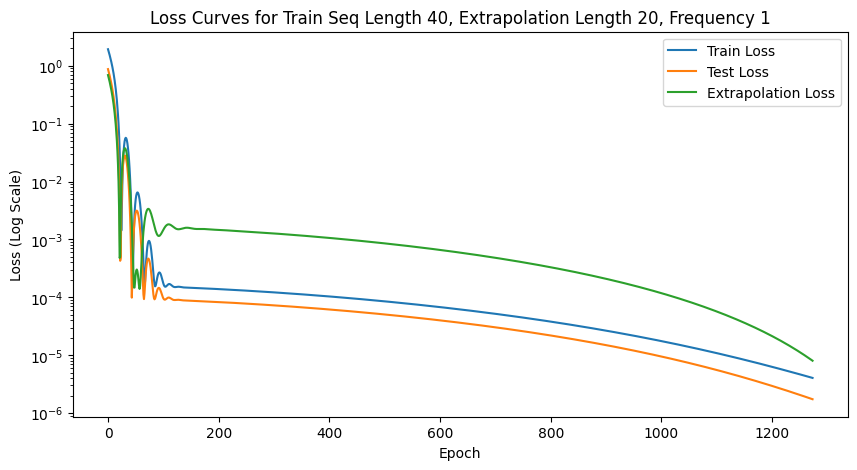

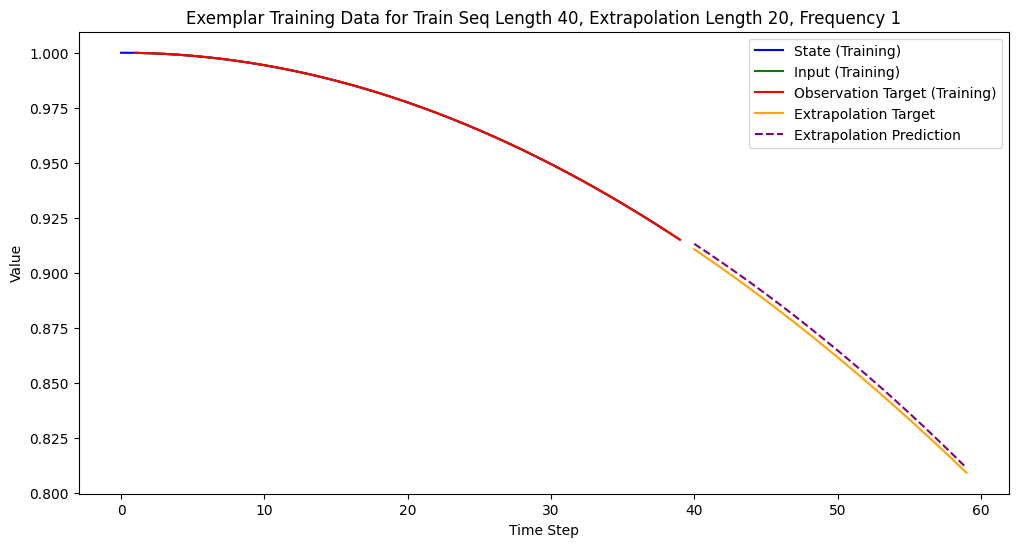

Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 10, Train Loss: 7.493e-01, Test Loss: 3.350e-01, Extrapolation Loss: 7.695e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 20, Train Loss: 8.002e-02, Test Loss: 3.209e-02, Extrapolation Loss: 3.457e-03
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 30, Train Loss: 4.641e-02, Test Loss: 2.035e-02, Extrapolation Loss: 6.153e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 40, Train Loss: 1.327e-02, Test Loss: 7.256e-03, Extrapolation Loss: 4.101e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 50, Train Loss: 6.516e-03, Test Loss: 2.583e-03, Extrapolation Loss: 1.403e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 60, Train Loss: 3.649e-03, Test Loss: 2.264e-03, Extrapolation Loss: 1.342e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 70, Train Loss: 1.980e-03, Test Loss: 9.961e-04, Extrapolation Loss: 1.

KeyboardInterrupt: 

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Function to generate cosine data with varying frequencies
def generate_cosine_data(seq_length, num_sequences, frequency):
    x = torch.linspace(0, 2 * math.pi * frequency/10, seq_length)
    data = torch.cos(x).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
frequencies = [1, 2, 3]  # Testing with a single frequency for simplicity
train_seq_lengths = [40, 60, 80]  # Different lengths of training sequences
extrapolation_lengths = [20, 40, 60]  # Lengths of extrapolation sequences
convergence_std_threshold = 1e-6  # Added line for the standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    for extrapolation_length in extrapolation_lengths:
        total_seq_length = train_seq_length + extrapolation_length
        
        for freq in frequencies:
            model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.MSELoss()
            
            # Generate data
            data = generate_cosine_data(total_seq_length, num_sequences, freq)
            
            # Split into train and test sets
            train_size = int(0.8 * num_sequences)
            test_size = num_sequences - train_size
            
            train_data = data[:train_size]
            test_data = data[train_size:]
            
            train_losses = []
            test_losses = []
            best_loss = float('inf')
            patience_counter = 0
            
            epoch = 0
            while patience_counter < patience:
                model.train()
                optimizer.zero_grad()
                
                state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
                input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
                observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
                
                state = state.reshape(-1, state_dim)
                input = input.reshape(-1, input_dim)
                observation_target = observation_target.reshape(-1, output_dim)
                
                next_state, observation = model(state, input)
                loss = criterion(next_state, state) + criterion(observation, observation_target)
                
                loss.backward()
                optimizer.step()
                
                train_losses.append(loss.item())

                # Check convergence criteria based on the standard deviation of the last few training losses
                if len(train_losses) > n_pts:
                    recent_losses = train_losses[-n_pts:]
                    std_recent_losses = np.std(recent_losses)
                    if std_recent_losses < convergence_std_threshold:
                        patience_counter += 1
                    else:
                        patience_counter = 0
                else:
                    patience_counter = 0
                

                
                # Validation on test data
                model.eval()
                with torch.no_grad():
                    test_state = test_data[:, :train_seq_length-1, :]
                    test_input = test_data[:, 1:train_seq_length, :]
                    
                    test_state = test_state.reshape(-1, state_dim)
                    test_input = test_input.reshape(-1, input_dim)
                    
                    _, test_observation = model(test_state, test_input)
                    
                    extrap_state = test_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
                    extrap_input = test_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
                    extrap_target = test_data[:, train_seq_length:, :]  # Extrapolation target is the next value
                    
                    extrap_state = extrap_state.reshape(-1, state_dim)
                    extrap_input = extrap_input.reshape(-1, input_dim)
                    extrap_target = extrap_target.reshape(-1, output_dim)
                    
                    _, extrap_observation = model(extrap_state, extrap_input)
                    
                    test_loss = criterion(test_observation, test_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
                    extrapolation_loss = criterion(extrap_observation, extrap_target)
                    test_losses.append((test_loss.item(), extrapolation_loss.item()))


                if (epoch + 1) % 10 == 0:
                    print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
                
                epoch += 1
            
            # Save performance data
            performance_data.append({
                "train_seq_length": train_seq_length,
                "extrapolation_length": extrapolation_length,
                "frequency": freq,
                "final_train_loss": train_losses[-1],
                "final_test_loss": test_losses[-1][0],
                "final_extrapolation_loss": test_losses[-1][1]
            })
            
            # Plot loss curves
            train_losses = np.array(train_losses)
            test_losses = np.array(test_losses)
            
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses[:, 0], label="Test Loss")
            plt.plot(test_losses[:, 1], label="Extrapolation Loss")
            plt.yscale('log')
            plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss (Log Scale)")
            plt.legend()
            plt.show()
            
            # Plot exemplar training data
            exemplar_index = 0
            exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
            exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
            exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
            exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

            # Get the model prediction for the extrapolation regime
            model.eval()
            with torch.no_grad():
                extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
                extrap_input = train_data[exemplar_index, train_seq_length:, :]
                
                extrap_state = extrap_state.reshape(-1, state_dim)
                extrap_input = extrap_input.reshape(-1, input_dim)
                
                _, extrap_prediction = model(extrap_state, extrap_input)
                extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

            plt.figure(figsize=(12, 6))
            plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
            plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
            plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
            plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
            plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
            plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()
            plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Test Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}, Frequency {data['frequency']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


In [8]:
performance_df

,train_seq_length,extrapolation_length,frequency,final_train_loss,final_test_loss,final_extrapolation_loss
0,20,10,1,0.000012,0.000004,0.017147
1,20,10,2,0.000009,0.000005,0.000013
2,20,10,3,0.000011,0.000004,0.000011
3,20,20,1,0.000014,0.000003,0.012379
4,20,20,2,0.000008,0.000004,0.000004
5,20,20,3,0.000003,0.000001,0.000002
6,20,30,1,0.000006,0.000003,0.006374
7,20,30,2,0.000005,0.000003,0.000098
8,20,30,3,0.000012,0.000006,0.000009
9,30,10,1,0.000007,0.000004,0.002398


# Harmonic Oscillator - SSKAN

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 4.269e-01, Test Loss: 1.918e-01, Extrapolation Loss: 1.796e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 1.081e-01, Test Loss: 4.130e-02, Extrapolation Loss: 2.740e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 2.467e-02, Test Loss: 8.389e-03, Extrapolation Loss: 8.657e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 2.219e-02, Test Loss: 7.076e-03, Extrapolation Loss: 9.858e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 7.367e-03, Test Loss: 1.935e-03, Extrapolation Loss: 4.849e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 5.959e-03, Test Loss: 1.789e-03, Extrapolation Loss: 4.235e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 3.475e-03, Test Loss: 9.665e-04, Extrapolation Loss: 5.224e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 2.921e-

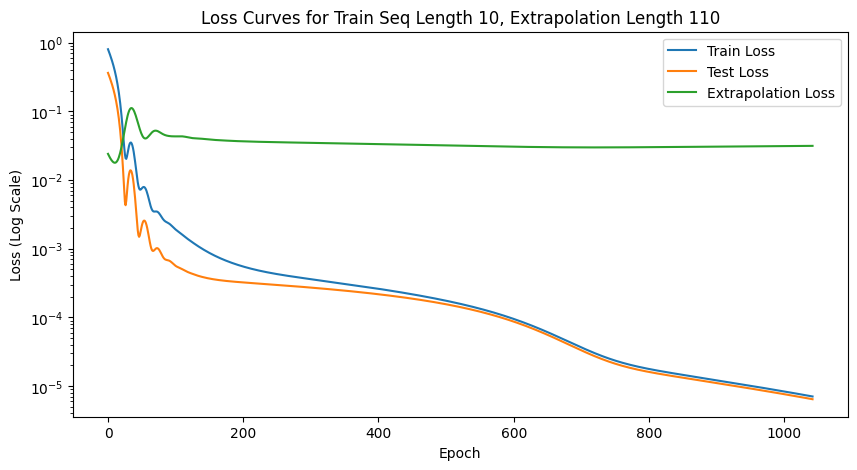

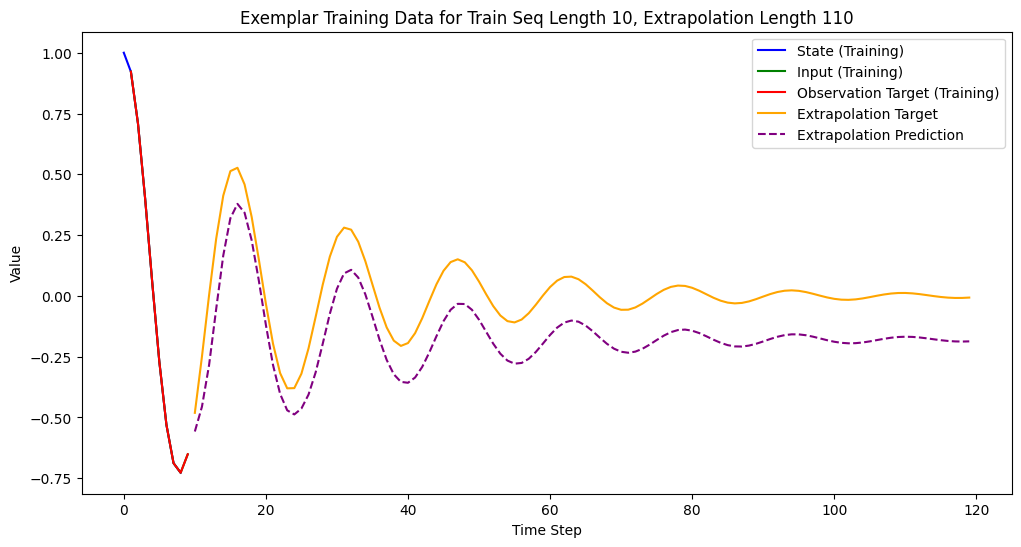

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 3.311e-01, Test Loss: 1.363e-01, Extrapolation Loss: 1.155e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 9.172e-02, Test Loss: 3.325e-02, Extrapolation Loss: 8.237e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 3.627e-02, Test Loss: 2.057e-02, Extrapolation Loss: 9.149e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 2.958e-02, Test Loss: 1.239e-02, Extrapolation Loss: 3.511e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 1.845e-02, Test Loss: 8.981e-03, Extrapolation Loss: 2.131e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 1.413e-02, Test Loss: 6.031e-03, Extrapolation Loss: 1.047e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 1.009e-02, Test Loss: 4.220e-03, Extrapolation Loss: 6.200e-04
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 7.054e-

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
    
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    train_data, train_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    
    # Split into train and test sets
    train_size = int(num_sequences)

    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(state, input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = train_data[:, :train_seq_length-1, :]
            test_input = train_data[:, 1:train_seq_length, :]
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            extrap_state = train_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = train_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_target = train_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_input = extrap_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            _, extrap_observation = model(extrap_state, extrap_input)
            
            test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            extrapolation_loss = criterion(extrap_observation, extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_input = extrap_input.reshape(-1, input_dim)
        
        _, extrap_prediction = model(extrap_state, extrap_input)
        extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
    plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
    plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


# Harmonic Oscillator - NN

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
nn_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
    
    model = NN(input_dim, nn_layers, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    train_data, train_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    
    # Split into train and test sets
    train_size = int(num_sequences)

    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = train_data[:, :train_seq_length-1, :]
            test_input = train_data[:, 1:train_seq_length, :]
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            extrap_state = train_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = train_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_target = train_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_input = extrap_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            _, extrap_observation = model(extrap_state, extrap_input)
            
            test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            extrapolation_loss = criterion(extrap_observation, extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_input = extrap_input.reshape(-1, input_dim)
        
        _, extrap_prediction = model(extrap_state, extrap_input)
        extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
    plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
    plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


ValueError: too many values to unpack (expected 2)

# Harmonic Oscillator - SSKAN with time input

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences, t

# Parameters
state_dim = 1
input_dim = 2
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences
convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 2, 20

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
        
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    data, t = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    t = t.unsqueeze(0).repeat(num_sequences, 1)
    
    # Split into train and test sets
    train_size = int(0.8 * num_sequences)
    test_size = num_sequences - train_size
    
    train_data = data[:train_size]
    train_time = t[:train_size]
    test_data = data[train_size:]
    test_time = t[train_size:]
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        time_input = train_time[:, 1:train_seq_length].unsqueeze(-1)
        combined_input = torch.cat((input, time_input), dim=-1)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        combined_input = combined_input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        observation = model(state, combined_input)
        loss = criterion(observation[-1], observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = test_data[:, :train_seq_length-1, :]
            test_input = test_data[:, 1:train_seq_length, :]
            test_time_input = test_time[:, 1:train_seq_length].unsqueeze(-1)
            test_combined_input = torch.cat((test_input, test_time_input), dim=-1)
            
            test_state = test_state.reshape(-1, state_dim)
            test_combined_input = test_combined_input.reshape(-1, input_dim)
            
            test_observation = model(test_state, test_combined_input)
            test_loss = criterion(test_observation[-1], test_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            
            extrap_state = test_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = test_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_time_input = test_time[:, train_seq_length:].unsqueeze(-1)
            extrap_combined_input = torch.cat((extrap_input, extrap_time_input), dim=-1)
            extrap_target = test_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_combined_input = extrap_combined_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            extrap_observation = model(extrap_state, extrap_combined_input)
            extrapolation_loss = criterion(extrap_observation[-1], extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_train_time = train_time[exemplar_index, 1:train_seq_length].cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()
    exemplar_extrap_time = train_time[exemplar_index, train_seq_length:].cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        extrap_time = train_time[exemplar_index, train_seq_length:].unsqueeze(-1)
        extrap_combined_input = torch.cat((extrap_input, extrap_time), dim=-1)
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_combined_input = extrap_combined_input.reshape(-1, input_dim)
        
        extrap_prediction = model(extrap_state, extrap_combined_input)
        extrap_prediction = extrap_prediction[-1].cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(exemplar_train_time, exemplar_input, label="Input (Training)", color='green')
    plt.plot(exemplar_train_time, exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(exemplar_extrap_time, exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(exemplar_extrap_time, extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Plot exemplar test data
    exemplar_test_state = test_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_test_input = test_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_test_train_time = test_time[exemplar_index, 1:train_seq_length].cpu().numpy()
    exemplar_test_target = test_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_test_extrapolation = test_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()
    exemplar_test_extrap_time = test_time[exemplar_index, train_seq_length:].cpu().numpy()

    # Get the model prediction for the extrapolation regime on test data
    with torch.no_grad():
        extrap_test_state = test_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_test_input = test_data[exemplar_index, train_seq_length:, :]
        extrap_test_time = test_time[exemplar_index, train_seq_length:].unsqueeze(-1)
        extrap_test_combined_input = torch.cat((extrap_test_input, extrap_test_time), dim=-1)
        
        extrap_test_state = extrap_test_state.reshape(-1, state_dim)
        extrap_test_combined_input = extrap_test_combined_input.reshape(-1, input_dim)
        
        extrap_test_prediction = model(extrap_test_state, extrap_test_combined_input)
        extrap_test_prediction = extrap_test_prediction[-1].cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(exemplar_test_train_time, exemplar_test_input, label="Input (Training)", color='green')
    plt.plot(exemplar_test_train_time, exemplar_test_target, label="Observation Target (Training)", color='red')
    plt.plot(exemplar_test_extrap_time, exemplar_test_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(exemplar_test_extrap_time, extrap_test_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Test Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Test Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


NameError: name 'StateSpaceModel' is not defined

In [20]:
observation

(tensor([[-1.0608e-02],
         [-1.0544e-02],
         [-1.0186e-02],
         [-9.4877e-03],
         [-8.4834e-03],
         [-7.2232e-03],
         [-5.6404e-03],
         [-3.7167e-03],
         [-1.7409e-03],
         [-7.2050e-05],
         [ 1.1739e-03],
         [ 2.0848e-03],
         [ 2.7577e-03],
         [ 3.2525e-03],
         [ 3.6053e-03],
         [ 3.8451e-03],
         [ 3.9880e-03],
         [ 4.0386e-03],
         [ 3.9938e-03],
         [ 3.8379e-03],
         [ 3.5234e-03],
         [ 2.9819e-03],
         [ 2.1492e-03],
         [ 1.0554e-03],
         [-1.7270e-04],
         [-1.3860e-03],
         [-2.4776e-03],
         [-3.4048e-03],
         [-4.1423e-03],
         [-1.0608e-02],
         [-1.0544e-02],
         [-1.0186e-02],
         [-9.4877e-03],
         [-8.4834e-03],
         [-7.2232e-03],
         [-5.6404e-03],
         [-3.7167e-03],
         [-1.7409e-03],
         [-7.2050e-05],
         [ 1.1739e-03],
         [ 2.0848e-03],
         [ 2.757

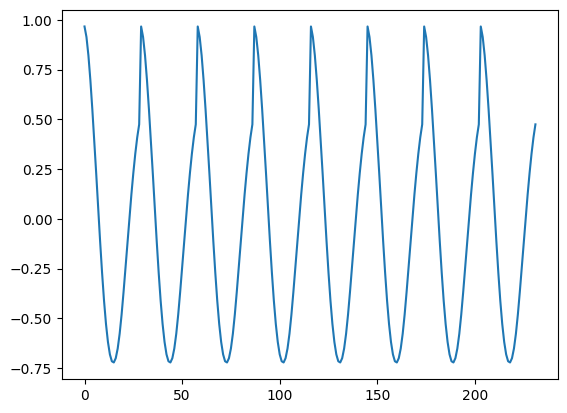

In [22]:
plt.plot(observation[0].detach().numpy()+observation[1].detach().numpy())

In [18]:
summary(model, input_size=[(batch_size, state_dim), (batch_size, input_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [10, 1]                   --
├─KAN: 1-1                               [10, 1]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [10, 64]                  1,920
│    │    └─KANLinear: 3-2               [10, 64]                  40,960
│    │    └─KANLinear: 3-3               [10, 1]                   640
├─KAN: 1-2                               [10, 1]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [10, 64]                  1,920
│    │    └─KANLinear: 3-5               [10, 64]                  40,960
│    │    └─KANLinear: 3-6               [10, 1]                   640
Total params: 87,040
Trainable params: 87,040
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass si

# Simple KAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import optuna
from torch.utils.tensorboard import SummaryWriter
from flask import Flask, request, jsonify

class KAN(nn.Module):
    def __init__(self, input_size, inner_size):
        super(KAN, self).__init__()
        self.inner_weights = nn.Linear(input_size, inner_size)
        self.outer_weights = nn.Linear(inner_size, 1)
        self.phi = nn.Tanh()

    def forward(self, x):
        z = self.inner_weights(x)
        v = self.phi(z)
        y = self.outer_weights(v)
        return y

def objective(trial):
    inner_size = trial.suggest_int('inner_size', 5, 20)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model = KARN(input_size, inner_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
    train_model(model, criterion, optimizer, scheduler, train_loader, 300, model_path)
    val_loss = evaluate_model(model, x_val, y_val)
    trial.report(val_loss, 300)
    return val_loss

def train_model(model, criterion, optimizer, scheduler, data_loader, epochs, model_path):
    writer = SummaryWriter()  # TensorBoard
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        writer.add_scalar('Loss/train', total_loss / len(data_loader), epoch)
        if epoch % 100 == 0:
            torch.save(model.state_dict(), model_path)

def evaluate_model(model, x_val, y_val):
    model.eval()
    with torch.no_grad():
        val_predictions = model(x_val)
        val_loss = criterion(val_predictions, y_val)
    return val_loss.item()
model = KARN(input_size=1, inner_size=1)
train_model(model, criterion, optimizer, scheduler, data_loader, epochs, model_path)

NameError: name 'model_path' is not defined